# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli India**

## Caricamento dei Datasets ed Import Librerie



In [1]:
!pip install pykan

In [2]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import json
import inspect
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import types
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn.utils.prune as prune
from torch.nn.functional import softmax

%pip install xgboost
import xgboost as xgb
from kan import *

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [4]:
github_url = 'https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_india_dataset.csv'
local_path = '/scratch.hpc/martin.tomassi/datasets_pm'
local_file = os.path.join(local_path, 'original_india_dataset.csv')

if not os.path.exists(local_path):
    os.makedirs(local_path)

if not os.path.exists(local_file):
    df = pd.read_csv(github_url,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)
    df.to_csv(local_file, index=False)
    print("File scaricato e salvato in locale.")
else:
    print("Il file esiste già in locale, lo carico...")
    df = pd.read_csv(local_file,
                     sep=',',
                     quotechar='"',
                     dtype=None,
                     parse_dates=True,
                     low_memory=False)

obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2018)]
df = df.reset_index(drop=True)
df.head()

File scaricato e salvato in locale.


,year,month,dayofmonth,state,PM2.5,CO,O3,dayofweek,quarter,weekofyear,...,pm_lag_1D,co_lag_1D,o3_lag_1D,pm_lag_2D,co_lag_2D,o3_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,Class
0,2018,1,1,Bihar,248.338542,1.253194,25.368750,0,1,1,...,205.467292,1.088611,23.453125,265.163333,1.719167,12.699167,234.609375,1.699861,11.677917,6
1,2018,1,1,Odisha,48.950000,3.310000,0.020000,0,1,1,...,48.950000,3.310000,0.020000,48.950000,3.447083,0.020000,48.950000,3.357083,0.015000,3
2,2018,1,1,West Bengal,11.015000,0.985417,13.758958,0,1,1,...,11.015000,1.000833,14.120625,11.015000,0.877500,12.428333,11.015000,1.125000,12.632708,2
3,2018,1,1,Andhra Pradesh,53.847778,0.723542,51.598333,0,1,1,...,51.303542,0.657500,49.261250,50.059861,0.672188,43.236424,56.092118,0.733437,43.451597,3
4,2018,1,1,Gujarat,84.484167,0.863750,44.890000,0,1,1,...,83.526250,0.887500,64.475833,81.357083,1.103750,51.791667,85.548750,1.254167,56.731667,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43961 entries, 0 to 43960
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        43961 non-null  int64   
 1   month       43961 non-null  int64   
 2   dayofmonth  43961 non-null  int64   
 3   state       43961 non-null  category
 4   PM2.5       43961 non-null  float64 
 5   CO          43961 non-null  float64 
 6   O3          43961 non-null  float64 
 7   dayofweek   43961 non-null  int64   
 8   quarter     43961 non-null  int64   
 9   weekofyear  43961 non-null  int64   
 10  dayofyear   43961 non-null  int64   
 11  pm_lag_1Y   38402 non-null  float64 
 12  co_lag_1Y   38402 non-null  float64 
 13  o3_lag_1Y   38402 non-null  float64 
 14  pm_lag_2Y   32899 non-null  float64 
 15  co_lag_2Y   32899 non-null  float64 
 16  o3_lag_2Y   32899 non-null  float64 
 17  pm_lag_1M   43541 non-null  float64 
 18  co_lag_1M   43541 non-null  float64 
 19  o3_l

In [6]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
2    17970
4    11947
3     9110
1     2573
5     1989
6      372
Name: count, dtype: int64


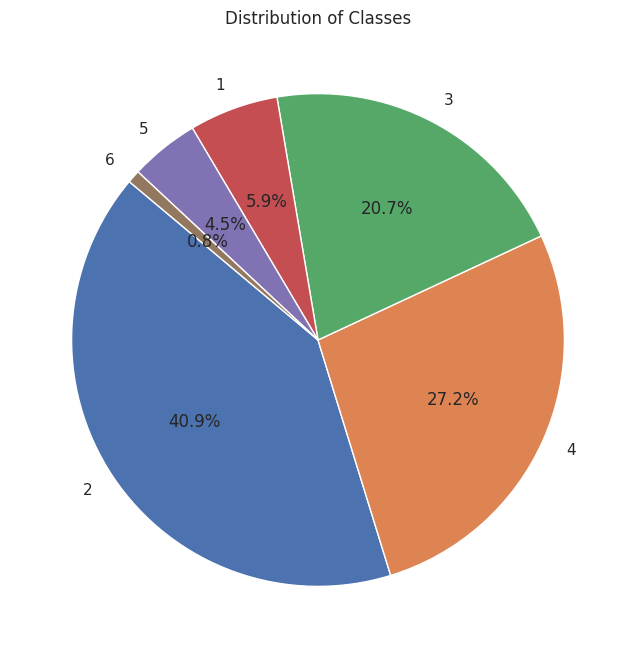

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni

La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [8]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_2Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y', 'co_lag_2Y', 'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_2Y', 'o3_lag_1M', 'o3_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [9]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [10]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

/scratch.hpc/martin.tomassi/venv_pm/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26319 entries, 0 to 26318
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  26319 non-null  int64   
 1   dayofweek   26319 non-null  int64   
 2   dayofyear   26319 non-null  int64   
 3   weekofyear  26319 non-null  int64   
 4   month       26319 non-null  int64   
 5   quarter     26319 non-null  int64   
 6   year        26319 non-null  int64   
 7   state       26319 non-null  category
 8   pm_lag_1Y   26319 non-null  float64 
 9   pm_lag_2Y   26319 non-null  float64 
 10  pm_lag_1M   26319 non-null  float64 
 11  pm_lag_1W   26319 non-null  float64 
 12  co_lag_1Y   26319 non-null  float64 
 13  co_lag_2Y   26319 non-null  float64 
 14  co_lag_1M   26319 non-null  float64 
 15  co_lag_1W   26319 non-null  float64 
 16  o3_lag_1Y   26319 non-null  float64 
 17  o3_lag_2Y   26319 non-null  float64 
 18  o3_lag_1M   26319 non-null  float64 
 19  o3_l

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   dayofmonth  6580 non-null   int64   
 1   dayofweek   6580 non-null   int64   
 2   dayofyear   6580 non-null   int64   
 3   weekofyear  6580 non-null   int64   
 4   month       6580 non-null   int64   
 5   quarter     6580 non-null   int64   
 6   year        6580 non-null   int64   
 7   state       6580 non-null   category
 8   pm_lag_1Y   6580 non-null   float64 
 9   pm_lag_2Y   6580 non-null   float64 
 10  pm_lag_1M   6580 non-null   float64 
 11  pm_lag_1W   6580 non-null   float64 
 12  co_lag_1Y   6580 non-null   float64 
 13  co_lag_2Y   6580 non-null   float64 
 14  co_lag_1M   6580 non-null   float64 
 15  co_lag_1W   6580 non-null   float64 
 16  o3_lag_1Y   6580 non-null   float64 
 17  o3_lag_2Y   6580 non-null   float64 
 18  o3_lag_1M   6580 non-null   float64 
 19  o3_lag

In [13]:
print(y_train.value_counts())

Class
2    10177
4     8159
3     5925
5     1436
6      323
1      299
Name: count, dtype: int64


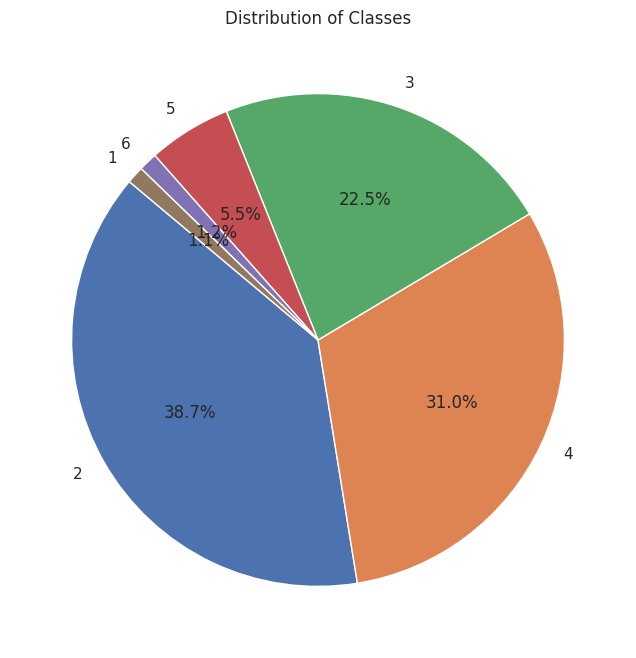

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [15]:
print(y_test.value_counts())

Class
2    2727
4    1831
3    1364
1     321
5     307
6      30
Name: count, dtype: int64


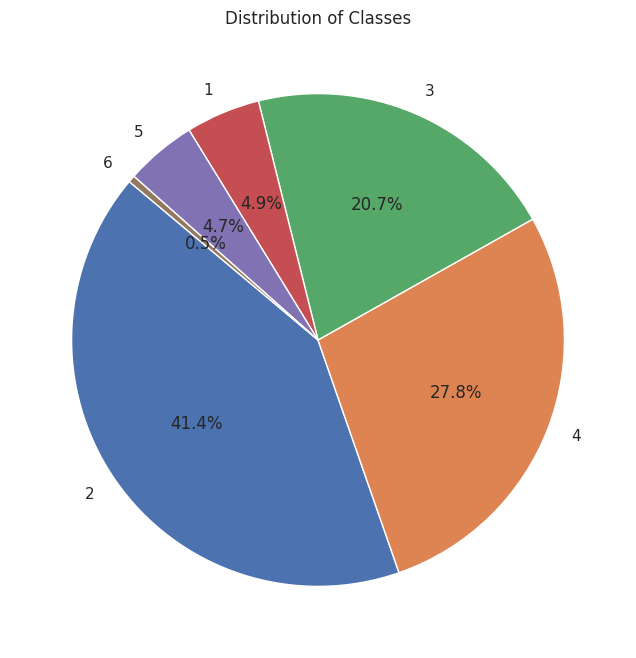

In [16]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [17]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [18]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [19]:
def count_params(model):
    if isinstance(model, ImbPipeline):
        model = model.steps[-1][1]

    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0
            else:
                sum_edge_terms = 0
                for i in range(len(model.width) - 1):
                    Nl = model.width[i]
                    Nl_plus_1 = model.width[i+1]
                    if isinstance(Nl, list): Nl = Nl[0]
                    if isinstance(Nl_plus_1, list): Nl_plus_1 = Nl_plus_1[0]
                    G = model.grid
                    k = model.k
                    sum_edge_terms += Nl * Nl_plus_1 * (G + k - 1)
                return sum_edge_terms
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0

    elif isinstance(model, RandomForestClassifier):
        total_nodes = 0
        if hasattr(model, 'estimators_'):
            for tree in model.estimators_:
                if hasattr(tree, 'tree_'):
                    total_nodes += tree.tree_.node_count
            return total_nodes
        else:
            return 0

    elif isinstance(model, xgb.XGBClassifier):
        total_nodes = 0

        try:
            booster = model.get_booster()
            tree_dumps = booster.get_dump(dump_format='json')

            def count_nodes_in_json_tree(node):
                count = 1
                if 'children' in node:
                    for child in node['children']:
                        count += count_nodes_in_json_tree(child)
                return count

            for tree_dump_str in tree_dumps:
                tree_json = json.loads(tree_dump_str)
                total_nodes += count_nodes_in_json_tree(tree_json)

            return total_nodes
        except Exception as e:
            print(f"Error calculating exact XGBoost complexity: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Calcola la Complessitá dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters/Nodes: {param_count}")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Calcola il numero di Parametri dei Modelli
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


Fold 1:
-- Training set class distribution: --
Class
1       2
2    1016
3    1000
4    1740
5     492
6     139
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      45
2    1786
3    1288
4    1139
5     114
6      14
Name: count, dtype: int64
--------------------
Fold 2:
-- Training set class distribution: --
Class
1      47
2    2802
3    2288
4    2879
5     606
6     153
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      23
2    1692
3     980
4    1375
5     252
6      64
Name: count, dtype: int64
--------------------
Fold 3:
-- Training set class distribution: --
Class
1      70
2    4494
3    3268
4    4254
5     858
6     217
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      31
2    1697
3     812
4    1467
5     313
6      66
Name: count, dtype: int64
--------------------


Fold 4:
-- Training set class distribution: --
Class
1     101
2    6191
3    4080
4    5721
5    1171
6     283
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1     133
2    2651
3     888
4     654
5      44
6      16
Name: count, dtype: int64
--------------------
Fold 5:
-- Training set class distribution: --
Class
1     234
2    8842
3    4968
4    6375
5    1215
6     299
Name: count, dtype: int64
-- Validation set class distribution: --
Class
1      65
2    1335
3     957
4    1784
5     221
6      24
Name: count, dtype: int64
--------------------


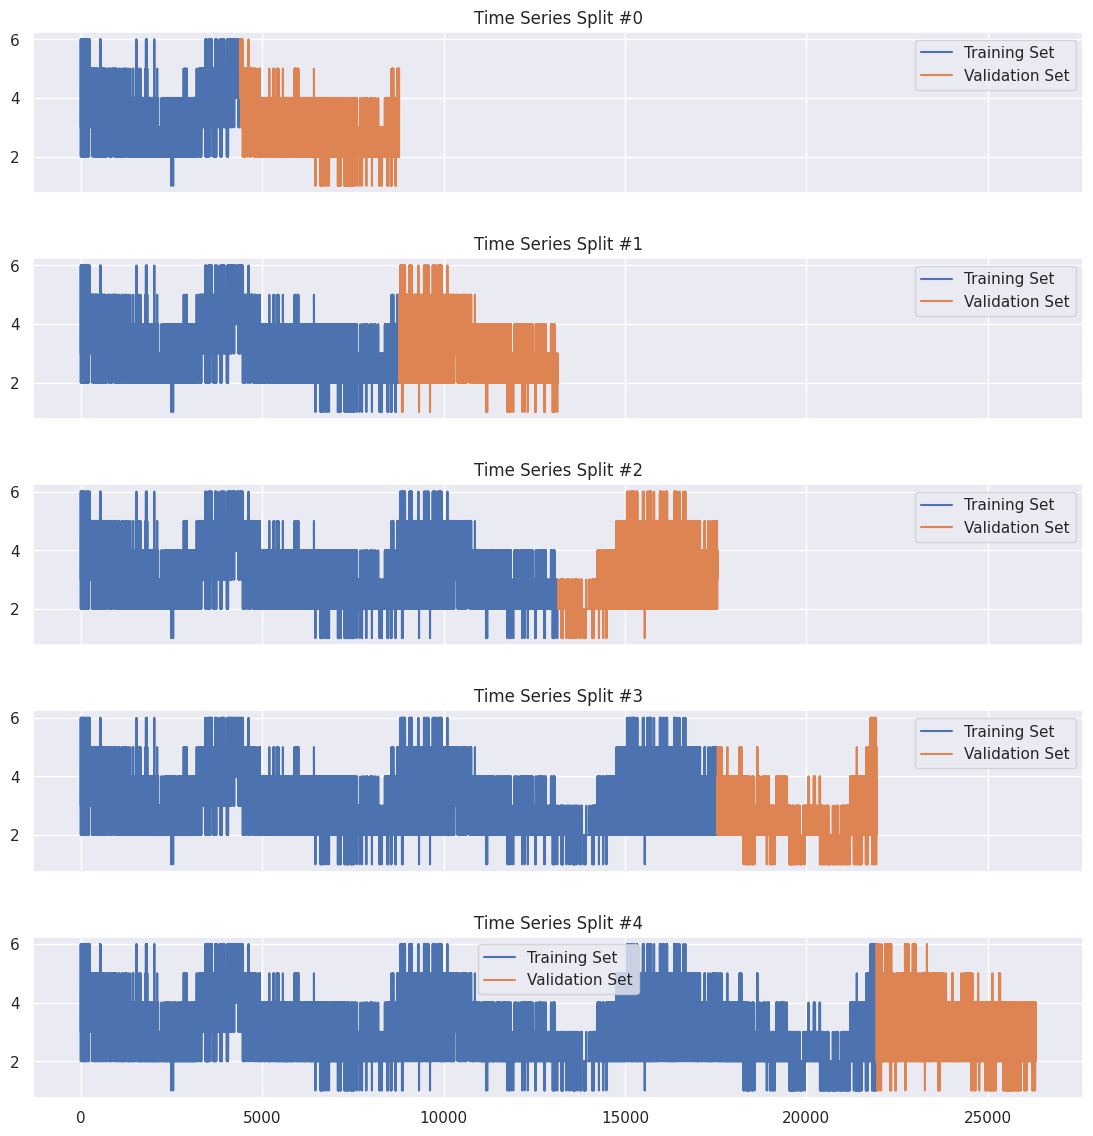

In [21]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

    print(f"Fold {index+1}:")
    print("-- Training set class distribution: --")
    print(y_train.iloc[train_fold].value_counts().sort_index())
    print("-- Validation set class distribution: --")
    print(y_train.iloc[validation_fold].value_counts().sort_index())
    print("-" * 20)

plt.show()

## Custom SMOTE for Random Forest and XGBoost

In [22]:
class SmoteKNeighbors(SMOTE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _fit_resample(self, X, y):
        counts = np.bincount(y)
        minority_class = np.argmin(counts)
        n_samples_minority = counts[minority_class]

        if self.k_neighbors >= n_samples_minority:
            new_k_neighbors = max(1, n_samples_minority - 1)

            original_k_neighbors = self.k_neighbors
            self.k_neighbors = new_k_neighbors

            print(f"Warning: k_neighbors too high. Adjusting from {original_k_neighbors} to {self.k_neighbors} for this fold.")

            X_res, y_res = super()._fit_resample(X, y)

            self.k_neighbors = original_k_neighbors

            return X_res, y_res
        else:
            return super()._fit_resample(X, y)

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [23]:
y_train_rf = y_train - 1
y_test_rf = y_test - 1

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [24]:
%time model.fit(X_train, y_train_rf)
print()

CPU times: user 21.9 s, sys: 97.9 ms, total: 22 s
Wall time: 5.84 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [25]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D    0.223789
numeric__pm_lag_2D    0.109891
numeric__pm_lag_3D    0.092542
numeric__pm_lag_1W    0.060801
numeric__pm_lag_1Y    0.044712
numeric__co_lag_1D    0.042311
numeric__pm_lag_2Y    0.035234
numeric__pm_lag_1M    0.032467
numeric__co_lag_2D    0.028231
numeric__co_lag_3D    0.024183
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

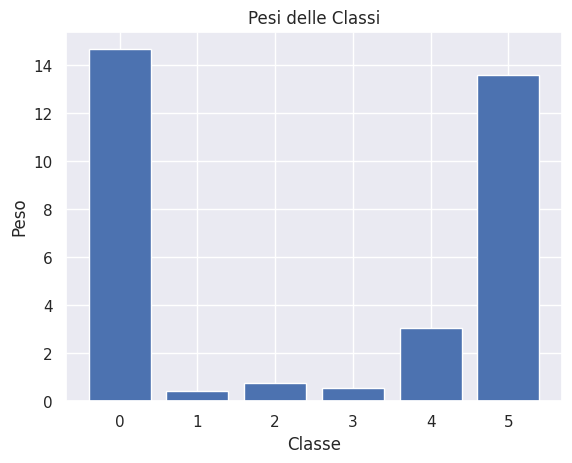

In [26]:
class_labels = np.unique(y_train_rf)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_rf)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [27]:
grid_rf = {
    'tree__n_estimators': [100, 150, 200],
    'tree__max_samples': [0.5, 0.7, 0.9],
    'tree__max_depth': [5, 10, 15],
    'tree__min_samples_split': [2, 5],
    'tree__min_samples_leaf': [2, 5],
    'tree__max_features': ['sqrt', 'log2']
}

model_ht_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

gs_rf = RandomizedSearchCV(model_ht_rf, grid_rf, n_iter=49, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 216
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 216.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{216}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{206}{216}\right)} = \frac{-2.3026}{\ln(206/216)} \approx \frac{2.3026}{0.0474} \approx 48.58
$$

Quindi, con **49 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 216 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [28]:
%time gs_rf.fit(X_train, y_train_rf)
print()

CPU times: user 26.3 s, sys: 846 ms, total: 27.1 s
Wall time: 11min 37s



In [29]:
best_params_rf = gs_rf.best_params_
print(best_params_rf)

{'tree__n_estimators': 100, 'tree__min_samples_split': 5, 'tree__min_samples_leaf': 2, 'tree__max_samples': 0.7, 'tree__max_features': 'sqrt', 'tree__max_depth': 15}


In [30]:
get_estimator_scores("random_forest", gs_rf.best_estimator_, X_test, y_test_rf, X_train, y_train_rf, all_scores)


--- Valutazione Prestazioni per random_forest ---
Model Parameters/Nodes: 412430



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       321
           1       0.89      0.86      0.88      2727
           2       0.65      0.70      0.67      1364
           3       0.85      0.80      0.82      1831
           4       0.61      0.82      0.70       307
           5       0.32      0.37      0.34        30

    accuracy                           0.80      6580
   macro avg       0.68      0.71      0.69      6580
weighted avg       0.81      0.80      0.80      6580


Confusion Matrix (Test Set):
[[ 233   88    0    0    0    0]
 [  73 2350  286   18    0    0]
 [   1  196  953  213    1    0]
 [   0    9  222 1456  143    1]
 [   0    1    0   32  252   22]
 [   0    0    0    0   19   11]]


AUC-ROC (OVR, Weighted): 0.952
AUC-PR (OVR, Weighted): 0.858


## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [31]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

In [32]:
%time model.fit(X_train, y_train_xgb)
print()

CPU times: user 33.4 s, sys: 340 ms, total: 33.7 s
Wall time: 8.81 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [33]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D                  0.373324
categorical__state_Mizoram          0.032396
categorical__state_Jharkhand        0.032081
categorical__state_Delhi            0.031139
categorical__state_Gujarat          0.025636
categorical__state_Bihar            0.024329
categorical__state_Uttar Pradesh    0.023500
categorical__state_Telangana        0.021301
categorical__state_Karnataka        0.017804
categorical__state_Assam            0.017711
dtype: float32

### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


---

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 432
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 432.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{432}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{422}{432}\right)} = \frac{-2.3026}{\ln(\frac{422}{432})} \approx \frac{2.3026}{0.0234} \approx 98.40
$$

Quindi, con **98** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 432 combinazioni.

---

In [34]:
grid_xgb = {
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__n_estimators": [100, 200, 300],
    "xgb__subsample": [0.7, 0.9],
    "xgb__colsample_bytree": [0.7, 0.9],
    "xgb__gamma": [0, 0.2, 0.4],
    "xgb__min_child_weight": [1, 5]
}

model_ht_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SmoteKNeighbors(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False,
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              verbosity=0,
                              random_state=RANDOM_STATE))
])

gs_xgb = RandomizedSearchCV(model_ht_xgb, grid_xgb, n_iter=98, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=0, random_state=RANDOM_STATE)

In [35]:
%time gs_xgb.fit(X_train, y_train_xgb)
print()

CPU times: user 43.2 s, sys: 1.87 s, total: 45.1 s
Wall time: 18min 7s



In [36]:
best_params_xgb = gs_xgb.best_params_
print(best_params_xgb)

{'xgb__subsample': 0.9, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.2, 'xgb__colsample_bytree': 0.7}


In [37]:
get_estimator_scores("xgboost", gs_xgb.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---


Model Parameters/Nodes: 90416



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       321
           1       0.89      0.87      0.88      2727
           2       0.67      0.68      0.68      1364
           3       0.83      0.85      0.84      1831
           4       0.69      0.70      0.70       307
           5       0.32      0.43      0.37        30

    accuracy                           0.81      6580
   macro avg       0.69      0.72      0.71      6580
weighted avg       0.81      0.81      0.81      6580


Confusion Matrix (Test Set):
[[ 253   68    0    0    0    0]
 [  79 2360  266   22    0    0]
 [   1  200  930  232    1    0]
 [   0    8  187 1556   78    2]
 [   0    1    0   64  216   26]
 [   0    0    0    0   17   13]]


AUC-ROC (OVR, Weighted): 0.957
AUC-PR (OVR, Weighted): 0.875


## MLP and KAN


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def build_kan(input_dim, width, grid, k, num_classes, seed=0):
    model = KAN(
        width=[input_dim] + list(width) + [num_classes],
        grid=grid,
        k=k,
        seed=seed,
        device=device
    )
    model.speed()  # enable efficient mode: disable symbolic branch
    return model

Device utilizzato: cuda


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [39]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [40]:
def train_epoch(model, loader, optimizer, criterion, l2_lambda=0.0):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)

        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [41]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None,
                  smote_k_neighbors=6):
    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Randomized Search")

    smote = SMOTE(
        k_neighbors=smote_k_neighbors,
        random_state=RANDOM_STATE
    )

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Estrai i dati del fold di training
            train_features = dataset.tensors[0][train_idx].cpu().numpy()
            train_labels = dataset.tensors[1][train_idx].cpu().numpy()

            # Estrai i dati di validazione
            val_features = dataset.tensors[0][val_idx]
            val_labels = dataset.tensors[1][val_idx]

            # Applica SMOTE al training set
            try:
                # Verifica che ci siano almeno 2 classi nel training set
                unique_classes = np.unique(train_labels)
                if len(unique_classes) < 2:
                    print(f"    Warning: Solo {len(unique_classes)} classe/i nel fold {fold_idx+1}. Skip SMOTE.")
                    train_features_resampled = train_features
                    train_labels_resampled = train_labels
                else:
                    # Verifica che ogni classe abbia almeno k_neighbors+1 campioni
                    min_samples = min([np.sum(train_labels == cls) for cls in unique_classes])
                    if min_samples <= smote_k_neighbors:
                        print(f"    Warning: Alcune classi hanno meno di {smote_k_neighbors+1} campioni. Riduco k_neighbors.")
                        smote_fold = SMOTE(
                            k_neighbors=min(min_samples-1, 1),
                            random_state=RANDOM_STATE
                        )
                    else:
                        smote_fold = smote

                    train_features_resampled, train_labels_resampled = smote_fold.fit_resample(
                        train_features, train_labels
                    )

                    print(f"    SMOTE applicato: {len(train_features)} -> {len(train_features_resampled)} campioni")

                    # Mostra la distribuzione delle classi dopo SMOTE
                    unique, counts = np.unique(train_labels_resampled, return_counts=True)
                    print(f"    Distribuzione post-SMOTE: {{{', '.join(f'{u}: {c}' for u, c in zip(unique, counts))}}}")

            except Exception as e:
                print(f"    Warning: SMOTE fallito ({str(e)}). Uso dataset originale.")
                train_features_resampled = train_features
                train_labels_resampled = train_labels

            # Converti back a tensori PyTorch
            train_features_tensor = torch.FloatTensor(train_features_resampled)
            train_labels_tensor = torch.LongTensor(train_labels_resampled)

            # Crea i dataset bilanciati
            balanced_train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
            val_dataset = TensorDataset(val_features, val_labels)

            # Crea i DataLoader
            train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            # Inizializza e addestra il modello
            model = model_builder(**model_params)
            if hasattr(model, 'speed'):
                model.speed()
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(1000):
                train_loss = train_epoch(model, train_loader, optimizer, criterion, l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [42]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(64,64), (128,), (128, 64), (256, 128), (512, 256)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}
kan_param_dist = {
    'input_dim': [input_dim],
    'width': [(8,4), (16, 8), (32, 16), (64, 32)],
    'grid': [5, 10, 20],
    'k': [2, 4],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'num_classes': [num_classes],
    'l2_lambda': [0.0, 1e-5, 1e-4, 1e-3]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [43]:
%%time
print("MLP Results:")
best_model_mlp, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=26
)

MLP Results:
Avvio Randomized Search
Testing parameter set 1/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.926405, val_loss = 0.878063


    Epoch 10: train_loss = 0.410801, val_loss = 0.796034
    Early stopping at epoch 10, best_val_loss: 0.761645
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.870909, val_loss = 0.929445


    Epoch 10: train_loss = 0.440258, val_loss = 0.761603


    Early stopping at epoch 13, best_val_loss: 0.746801
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.788469, val_loss = 0.804005


    Early stopping at epoch 9, best_val_loss: 0.541283
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.739406, val_loss = 0.761677


    Early stopping at epoch 7, best_val_loss: 0.545684
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.690211, val_loss = 0.682321


    Early stopping at epoch 7, best_val_loss: 0.638345
  Mean validation loss: 0.687859
  New best validation loss: 0.687859
Testing parameter set 2/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.609729, val_loss = 1.643774


    Epoch 10: train_loss = 0.651990, val_loss = 0.830873


    Epoch 20: train_loss = 0.571658, val_loss = 0.775143


    Epoch 30: train_loss = 0.526885, val_loss = 0.757587


    Epoch 40: train_loss = 0.503161, val_loss = 0.748144


    Early stopping at epoch 48, best_val_loss: 0.742147
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.449139, val_loss = 1.483297


    Epoch 10: train_loss = 0.635585, val_loss = 0.904593


    Epoch 20: train_loss = 0.568124, val_loss = 0.810626


    Epoch 30: train_loss = 0.528166, val_loss = 0.765486


    Epoch 40: train_loss = 0.501451, val_loss = 0.729995


    Epoch 50: train_loss = 0.476659, val_loss = 0.717317


    Epoch 60: train_loss = 0.453582, val_loss = 0.709367


    Early stopping at epoch 61, best_val_loss: 0.701361
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.320009, val_loss = 1.341814


    Epoch 10: train_loss = 0.614217, val_loss = 0.759531


    Epoch 20: train_loss = 0.548124, val_loss = 0.645717


    Epoch 30: train_loss = 0.512584, val_loss = 0.579064


    Epoch 40: train_loss = 0.488277, val_loss = 0.541519


    Epoch 50: train_loss = 0.472403, val_loss = 0.533474


    Epoch 60: train_loss = 0.451699, val_loss = 0.520986


    Early stopping at epoch 63, best_val_loss: 0.516294
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.273227, val_loss = 1.253831


    Epoch 10: train_loss = 0.582707, val_loss = 0.735561


    Epoch 20: train_loss = 0.521232, val_loss = 0.597506


    Epoch 30: train_loss = 0.486106, val_loss = 0.539780


    Epoch 40: train_loss = 0.462576, val_loss = 0.534060


    Early stopping at epoch 42, best_val_loss: 0.529154
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.148269, val_loss = 1.114865


    Epoch 10: train_loss = 0.549990, val_loss = 0.677375


    Epoch 20: train_loss = 0.499174, val_loss = 0.626990


    Epoch 30: train_loss = 0.467307, val_loss = 0.637982


    Early stopping at epoch 31, best_val_loss: 0.617562
  Mean validation loss: 0.628422
  New best validation loss: 0.628422
Testing parameter set 3/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.831997, val_loss = 0.883247


    Early stopping at epoch 8, best_val_loss: 0.799864
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.768944, val_loss = 0.871713


    Epoch 10: train_loss = 0.356931, val_loss = 0.793672


    Early stopping at epoch 12, best_val_loss: 0.735312
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.708451, val_loss = 0.747610


    Epoch 10: train_loss = 0.341391, val_loss = 0.583871
    Early stopping at epoch 10, best_val_loss: 0.548244
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.672031, val_loss = 0.859420


    Early stopping at epoch 7, best_val_loss: 0.561952
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.599306, val_loss = 0.625839


    Early stopping at epoch 6, best_val_loss: 0.621788
  Mean validation loss: 0.736510
Testing parameter set 4/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.460465, val_loss = 1.544238


    Epoch 10: train_loss = 0.636261, val_loss = 0.878442


    Epoch 20: train_loss = 0.546414, val_loss = 0.795467


    Epoch 30: train_loss = 0.498108, val_loss = 0.761581


    Epoch 40: train_loss = 0.465581, val_loss = 0.748517


    Epoch 50: train_loss = 0.443522, val_loss = 0.740930


    Epoch 60: train_loss = 0.428722, val_loss = 0.733372


    Early stopping at epoch 63, best_val_loss: 0.732845
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.404343, val_loss = 1.552465


    Epoch 10: train_loss = 0.625044, val_loss = 0.960916


    Epoch 20: train_loss = 0.550408, val_loss = 0.842303


    Epoch 30: train_loss = 0.506264, val_loss = 0.783872


    Epoch 40: train_loss = 0.477178, val_loss = 0.745224


    Epoch 50: train_loss = 0.458449, val_loss = 0.721578


    Epoch 60: train_loss = 0.439013, val_loss = 0.703711


    Epoch 70: train_loss = 0.427572, val_loss = 0.693852


    Early stopping at epoch 74, best_val_loss: 0.692568
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.293291, val_loss = 1.396621


    Epoch 10: train_loss = 0.594708, val_loss = 0.807090


    Epoch 20: train_loss = 0.521078, val_loss = 0.698094


    Epoch 30: train_loss = 0.486793, val_loss = 0.642635


    Epoch 40: train_loss = 0.459758, val_loss = 0.594101


    Epoch 50: train_loss = 0.444109, val_loss = 0.569497


    Epoch 60: train_loss = 0.431013, val_loss = 0.561457


    Epoch 70: train_loss = 0.421864, val_loss = 0.555159


    Epoch 80: train_loss = 0.411984, val_loss = 0.544701


    Early stopping at epoch 82, best_val_loss: 0.543805
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.199042, val_loss = 1.276179


    Epoch 10: train_loss = 0.563922, val_loss = 0.821660


    Epoch 20: train_loss = 0.494418, val_loss = 0.677118


    Epoch 30: train_loss = 0.460838, val_loss = 0.585946


    Epoch 40: train_loss = 0.440391, val_loss = 0.564527


    Epoch 50: train_loss = 0.423294, val_loss = 0.554633


    Early stopping at epoch 52, best_val_loss: 0.554262
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.109394, val_loss = 1.155300


    Epoch 10: train_loss = 0.521397, val_loss = 0.661787


    Epoch 20: train_loss = 0.468057, val_loss = 0.616362


    Epoch 30: train_loss = 0.438418, val_loss = 0.606094


    Early stopping at epoch 32, best_val_loss: 0.600830
  Mean validation loss: 0.628616
Testing parameter set 5/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.679217, val_loss = 0.777913


    Early stopping at epoch 5, best_val_loss: 0.777913
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.654014, val_loss = 0.771953


    Early stopping at epoch 7, best_val_loss: 0.693037
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.620690, val_loss = 0.682550


    Early stopping at epoch 7, best_val_loss: 0.533669
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.587087, val_loss = 0.568490


    Early stopping at epoch 5, best_val_loss: 0.568490
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.537988, val_loss = 0.726834


    Early stopping at epoch 6, best_val_loss: 0.656040
  Mean validation loss: 0.807971
Testing parameter set 6/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.734136, val_loss = 0.779543


    Early stopping at epoch 8, best_val_loss: 0.745473
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.707978, val_loss = 0.750304


    Early stopping at epoch 9, best_val_loss: 0.744689
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.661089, val_loss = 0.655805


    Early stopping at epoch 9, best_val_loss: 0.556064
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.629658, val_loss = 0.642142


    Early stopping at epoch 6, best_val_loss: 0.556545
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.590756, val_loss = 0.658696


    Early stopping at epoch 5, best_val_loss: 0.658696
  Mean validation loss: 0.740541
Testing parameter set 7/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.055272, val_loss = 1.013510


    Epoch 10: train_loss = 0.426718, val_loss = 0.757345


    Early stopping at epoch 13, best_val_loss: 0.735224
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.986212, val_loss = 1.012236


    Epoch 10: train_loss = 0.440683, val_loss = 0.749037


    Epoch 20: train_loss = 0.367634, val_loss = 0.692141


    Early stopping at epoch 25, best_val_loss: 0.692141
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.887509, val_loss = 0.874038


    Epoch 10: train_loss = 0.420450, val_loss = 0.572837


    Early stopping at epoch 19, best_val_loss: 0.522197
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.815296, val_loss = 0.816685


    Epoch 10: train_loss = 0.399514, val_loss = 0.588394


    Early stopping at epoch 12, best_val_loss: 0.570606
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.761093, val_loss = 0.753743


    Epoch 10: train_loss = 0.374152, val_loss = 0.646304


    Early stopping at epoch 11, best_val_loss: 0.613424
  Mean validation loss: 0.656490
Testing parameter set 8/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.858597, val_loss = 0.899911


    Early stopping at epoch 9, best_val_loss: 0.778319
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.794721, val_loss = 0.994307


    Epoch 10: train_loss = 0.358792, val_loss = 0.745244


    Early stopping at epoch 11, best_val_loss: 0.732814
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.739335, val_loss = 0.835073


    Epoch 10: train_loss = 0.347941, val_loss = 0.559518
    Early stopping at epoch 10, best_val_loss: 0.530735
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.693550, val_loss = 0.776032


    Early stopping at epoch 8, best_val_loss: 0.549161
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.635907, val_loss = 0.707690


    Early stopping at epoch 6, best_val_loss: 0.633766
  Mean validation loss: 0.702844
Testing parameter set 9/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.914218, val_loss = 0.820354


    Early stopping at epoch 9, best_val_loss: 0.746864
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.853189, val_loss = 0.974588


    Epoch 10: train_loss = 0.429208, val_loss = 0.816942


    Early stopping at epoch 13, best_val_loss: 0.750496
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.790355, val_loss = 0.807166


    Epoch 10: train_loss = 0.416620, val_loss = 0.544530


    Early stopping at epoch 12, best_val_loss: 0.529515
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.740320, val_loss = 0.825384


    Early stopping at epoch 9, best_val_loss: 0.589554
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.685834, val_loss = 0.700226


    Early stopping at epoch 6, best_val_loss: 0.658539
  Mean validation loss: 0.717543
Testing parameter set 10/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.426825, val_loss = 1.403664


    Epoch 10: train_loss = 0.610951, val_loss = 0.783457


    Epoch 20: train_loss = 0.528366, val_loss = 0.738327


    Epoch 30: train_loss = 0.476058, val_loss = 0.730375


    Early stopping at epoch 31, best_val_loss: 0.726208
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.300213, val_loss = 1.331915


    Epoch 10: train_loss = 0.606754, val_loss = 0.879250


    Epoch 20: train_loss = 0.533117, val_loss = 0.787380


    Epoch 30: train_loss = 0.481913, val_loss = 0.773543


    Early stopping at epoch 33, best_val_loss: 0.757995
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.199850, val_loss = 1.196444


    Epoch 10: train_loss = 0.580975, val_loss = 0.747188


    Epoch 20: train_loss = 0.505751, val_loss = 0.586442


    Epoch 30: train_loss = 0.460957, val_loss = 0.529309


    Epoch 40: train_loss = 0.430463, val_loss = 0.528258


    Early stopping at epoch 46, best_val_loss: 0.516866
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.119428, val_loss = 1.100428


    Epoch 10: train_loss = 0.550216, val_loss = 0.669991


    Epoch 20: train_loss = 0.479872, val_loss = 0.534426


    Early stopping at epoch 26, best_val_loss: 0.531133
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.022664, val_loss = 0.923721


    Epoch 10: train_loss = 0.516810, val_loss = 0.668375


    Early stopping at epoch 19, best_val_loss: 0.649113
  Mean validation loss: 0.647197
Testing parameter set 11/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.767980, val_loss = 0.839210


    Epoch 10: train_loss = 0.294365, val_loss = 0.846534


    Early stopping at epoch 11, best_val_loss: 0.772388
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.714263, val_loss = 1.003737


    Early stopping at epoch 9, best_val_loss: 0.754397
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.663222, val_loss = 0.760641


    Early stopping at epoch 7, best_val_loss: 0.525368
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.620560, val_loss = 0.612496


    Early stopping at epoch 6, best_val_loss: 0.553552
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.579100, val_loss = 0.644799


    Early stopping at epoch 6, best_val_loss: 0.574967
  Mean validation loss: 0.746006
Testing parameter set 12/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.877914, val_loss = 0.830351


    Epoch 10: train_loss = 0.402910, val_loss = 0.784730


    Early stopping at epoch 11, best_val_loss: 0.733506
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.796877, val_loss = 0.911927


    Early stopping at epoch 9, best_val_loss: 0.719030
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.751516, val_loss = 0.705028


    Epoch 10: train_loss = 0.415239, val_loss = 0.553930


    Early stopping at epoch 11, best_val_loss: 0.525770
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.703863, val_loss = 0.654920


    Early stopping at epoch 7, best_val_loss: 0.538733
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.663427, val_loss = 0.717060


    Early stopping at epoch 8, best_val_loss: 0.645866
  Mean validation loss: 0.698836
Testing parameter set 13/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.446151, val_loss = 1.554175


    Epoch 10: train_loss = 0.592894, val_loss = 0.879491


    Epoch 20: train_loss = 0.495264, val_loss = 0.812074


    Epoch 30: train_loss = 0.444077, val_loss = 0.783094


    Epoch 40: train_loss = 0.411095, val_loss = 0.771624


    Early stopping at epoch 49, best_val_loss: 0.764755
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.357776, val_loss = 1.508425


    Epoch 10: train_loss = 0.573754, val_loss = 0.937704


    Epoch 20: train_loss = 0.495130, val_loss = 0.823169


    Epoch 30: train_loss = 0.450601, val_loss = 0.769839


    Epoch 40: train_loss = 0.419967, val_loss = 0.736500


    Epoch 50: train_loss = 0.397573, val_loss = 0.728165


    Early stopping at epoch 57, best_val_loss: 0.721334
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.255602, val_loss = 1.368235


    Epoch 10: train_loss = 0.543452, val_loss = 0.820080


    Epoch 20: train_loss = 0.468995, val_loss = 0.701074


    Epoch 30: train_loss = 0.429370, val_loss = 0.632128


    Epoch 40: train_loss = 0.402197, val_loss = 0.599228


    Epoch 50: train_loss = 0.381924, val_loss = 0.579298


    Epoch 60: train_loss = 0.365558, val_loss = 0.564318


    Early stopping at epoch 69, best_val_loss: 0.552040
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.175234, val_loss = 1.236979


    Epoch 10: train_loss = 0.517517, val_loss = 0.754128


    Epoch 20: train_loss = 0.450314, val_loss = 0.626119


    Epoch 30: train_loss = 0.415047, val_loss = 0.571255


    Epoch 40: train_loss = 0.390864, val_loss = 0.555561


    Early stopping at epoch 44, best_val_loss: 0.554548
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.066368, val_loss = 1.124671


    Epoch 10: train_loss = 0.473509, val_loss = 0.661990


    Epoch 20: train_loss = 0.417552, val_loss = 0.629136


    Early stopping at epoch 28, best_val_loss: 0.625423
  Mean validation loss: 0.648099
Testing parameter set 14/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.615950, val_loss = 0.759342


    Early stopping at epoch 5, best_val_loss: 0.759342
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.618299, val_loss = 0.939482


    Early stopping at epoch 7, best_val_loss: 0.727665
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.582433, val_loss = 0.821244


    Early stopping at epoch 9, best_val_loss: 0.550143
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.549294, val_loss = 0.593225


    Early stopping at epoch 5, best_val_loss: 0.593225
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.521978, val_loss = 0.634732


    Early stopping at epoch 5, best_val_loss: 0.634732
  Mean validation loss: 0.844960
Testing parameter set 15/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.456493, val_loss = 1.611238


    Epoch 10: train_loss = 0.701606, val_loss = 0.926782


    Epoch 20: train_loss = 0.594413, val_loss = 0.816726


    Epoch 30: train_loss = 0.541570, val_loss = 0.774310


    Epoch 40: train_loss = 0.498908, val_loss = 0.753649


    Epoch 50: train_loss = 0.482127, val_loss = 0.740093


    Epoch 60: train_loss = 0.463055, val_loss = 0.732210


    Early stopping at epoch 65, best_val_loss: 0.732210
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.376699, val_loss = 1.523062


    Epoch 10: train_loss = 0.658082, val_loss = 0.950015


    Epoch 20: train_loss = 0.580609, val_loss = 0.838003


    Epoch 30: train_loss = 0.539222, val_loss = 0.781002


    Epoch 40: train_loss = 0.503702, val_loss = 0.754990


    Epoch 50: train_loss = 0.482603, val_loss = 0.735464


    Epoch 60: train_loss = 0.465345, val_loss = 0.725032


    Epoch 70: train_loss = 0.450695, val_loss = 0.719621


    Early stopping at epoch 72, best_val_loss: 0.715744
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.324668, val_loss = 1.471877


    Epoch 10: train_loss = 0.642717, val_loss = 0.901196


    Epoch 20: train_loss = 0.559302, val_loss = 0.773257


    Epoch 30: train_loss = 0.514730, val_loss = 0.681653


    Epoch 40: train_loss = 0.487561, val_loss = 0.635072


    Epoch 50: train_loss = 0.469803, val_loss = 0.592390


    Epoch 60: train_loss = 0.449113, val_loss = 0.572019


    Epoch 70: train_loss = 0.435401, val_loss = 0.560811


    Epoch 80: train_loss = 0.427853, val_loss = 0.543522


    Epoch 90: train_loss = 0.417373, val_loss = 0.537443


    Epoch 100: train_loss = 0.408236, val_loss = 0.531615


    Early stopping at epoch 104, best_val_loss: 0.530382
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.266682, val_loss = 1.308636


    Epoch 10: train_loss = 0.600948, val_loss = 0.799185


    Epoch 20: train_loss = 0.527486, val_loss = 0.688857


    Epoch 30: train_loss = 0.490424, val_loss = 0.608770


    Epoch 40: train_loss = 0.466654, val_loss = 0.558051


    Epoch 50: train_loss = 0.445934, val_loss = 0.545128


    Epoch 60: train_loss = 0.431594, val_loss = 0.544001


    Early stopping at epoch 62, best_val_loss: 0.537425
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.167491, val_loss = 1.241713


    Epoch 10: train_loss = 0.565942, val_loss = 0.722475


    Epoch 20: train_loss = 0.505346, val_loss = 0.654743


    Epoch 30: train_loss = 0.470132, val_loss = 0.642698


    Epoch 40: train_loss = 0.451694, val_loss = 0.636398


    Early stopping at epoch 42, best_val_loss: 0.628942
  Mean validation loss: 0.633053
Testing parameter set 16/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.513198, val_loss = 1.631656


    Epoch 10: train_loss = 0.704118, val_loss = 0.922512


    Epoch 20: train_loss = 0.593892, val_loss = 0.813110


    Epoch 30: train_loss = 0.544168, val_loss = 0.771890


    Epoch 40: train_loss = 0.503020, val_loss = 0.747929


    Epoch 50: train_loss = 0.476486, val_loss = 0.733824


    Epoch 60: train_loss = 0.462821, val_loss = 0.725851


    Early stopping at epoch 68, best_val_loss: 0.724326
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.409931, val_loss = 1.487306


    Epoch 10: train_loss = 0.662291, val_loss = 0.952193


    Epoch 20: train_loss = 0.585724, val_loss = 0.845558


    Epoch 30: train_loss = 0.538632, val_loss = 0.792771


    Epoch 40: train_loss = 0.503652, val_loss = 0.764234


    Epoch 50: train_loss = 0.482231, val_loss = 0.742619


    Epoch 60: train_loss = 0.464677, val_loss = 0.730447


    Early stopping at epoch 64, best_val_loss: 0.727046
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.344692, val_loss = 1.452391


    Epoch 10: train_loss = 0.636314, val_loss = 0.881070


    Epoch 20: train_loss = 0.559435, val_loss = 0.741830


    Epoch 30: train_loss = 0.514269, val_loss = 0.682139


    Epoch 40: train_loss = 0.487599, val_loss = 0.646929


    Epoch 50: train_loss = 0.471067, val_loss = 0.601379


    Epoch 60: train_loss = 0.454836, val_loss = 0.579657


    Epoch 70: train_loss = 0.439227, val_loss = 0.568025


    Early stopping at epoch 79, best_val_loss: 0.550856
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.238809, val_loss = 1.288413


    Epoch 10: train_loss = 0.600823, val_loss = 0.813320


    Epoch 20: train_loss = 0.532393, val_loss = 0.728019


    Epoch 30: train_loss = 0.494907, val_loss = 0.634598


    Epoch 40: train_loss = 0.465856, val_loss = 0.586662


    Epoch 50: train_loss = 0.445812, val_loss = 0.554578


    Epoch 60: train_loss = 0.433892, val_loss = 0.549332


    Early stopping at epoch 66, best_val_loss: 0.543327
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.168754, val_loss = 1.214513


    Epoch 10: train_loss = 0.558292, val_loss = 0.707135


    Epoch 20: train_loss = 0.494601, val_loss = 0.641000


    Early stopping at epoch 28, best_val_loss: 0.640860
  Mean validation loss: 0.640206
Testing parameter set 17/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.409102, val_loss = 1.449249


    Epoch 10: train_loss = 0.622111, val_loss = 0.777768


    Epoch 20: train_loss = 0.539217, val_loss = 0.733167


    Epoch 30: train_loss = 0.491482, val_loss = 0.723785


    Early stopping at epoch 32, best_val_loss: 0.719134
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.291146, val_loss = 1.311585


    Epoch 10: train_loss = 0.609789, val_loss = 0.861615


    Epoch 20: train_loss = 0.537850, val_loss = 0.787432


    Early stopping at epoch 26, best_val_loss: 0.755313
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.203329, val_loss = 1.212819


    Epoch 10: train_loss = 0.580313, val_loss = 0.720912


    Epoch 20: train_loss = 0.505134, val_loss = 0.582087


    Epoch 30: train_loss = 0.458059, val_loss = 0.525806


    Early stopping at epoch 35, best_val_loss: 0.525806
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.112955, val_loss = 1.127258


    Epoch 10: train_loss = 0.552805, val_loss = 0.671169


    Epoch 20: train_loss = 0.481157, val_loss = 0.557145


    Early stopping at epoch 24, best_val_loss: 0.549922
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.034725, val_loss = 0.973017


    Epoch 10: train_loss = 0.516352, val_loss = 0.697221


    Early stopping at epoch 16, best_val_loss: 0.674608
  Mean validation loss: 0.648920
Testing parameter set 18/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.835877, val_loss = 0.846646


    Early stopping at epoch 8, best_val_loss: 0.775907
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.779319, val_loss = 0.829976


    Early stopping at epoch 7, best_val_loss: 0.735208
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.720018, val_loss = 0.853449


    Epoch 10: train_loss = 0.344267, val_loss = 0.572418


    Early stopping at epoch 11, best_val_loss: 0.538125
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.662065, val_loss = 0.729432


    Early stopping at epoch 7, best_val_loss: 0.591564
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.600646, val_loss = 0.614227


    Early stopping at epoch 6, best_val_loss: 0.612914
  Mean validation loss: 0.727999
Testing parameter set 19/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.948246, val_loss = 0.922567


    Epoch 10: train_loss = 0.438452, val_loss = 0.729907


    Early stopping at epoch 14, best_val_loss: 0.719737
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.904652, val_loss = 1.005355


    Epoch 10: train_loss = 0.453969, val_loss = 0.723969


    Early stopping at epoch 14, best_val_loss: 0.713458
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.839372, val_loss = 0.889949


    Epoch 10: train_loss = 0.440343, val_loss = 0.556759


    Early stopping at epoch 19, best_val_loss: 0.536036
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.787560, val_loss = 0.865714


    Epoch 10: train_loss = 0.429669, val_loss = 0.593267


    Early stopping at epoch 11, best_val_loss: 0.566017
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.743145, val_loss = 0.727608


    Early stopping at epoch 9, best_val_loss: 0.662062
  Mean validation loss: 0.676143
Testing parameter set 20/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.844123, val_loss = 0.788382


    Early stopping at epoch 8, best_val_loss: 0.735800
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.815297, val_loss = 0.892801


    Epoch 10: train_loss = 0.438623, val_loss = 0.846053


    Early stopping at epoch 11, best_val_loss: 0.737289
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.769424, val_loss = 0.812010


    Early stopping at epoch 6, best_val_loss: 0.552843
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.737729, val_loss = 0.727015


    Early stopping at epoch 7, best_val_loss: 0.582833
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.682205, val_loss = 0.729211


    Early stopping at epoch 6, best_val_loss: 0.677336
  Mean validation loss: 0.733785
Testing parameter set 21/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.246619, val_loss = 1.197728


    Epoch 10: train_loss = 0.499403, val_loss = 0.744384


    Epoch 20: train_loss = 0.424143, val_loss = 0.723094


    Early stopping at epoch 28, best_val_loss: 0.716980
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.156254, val_loss = 1.241429


    Epoch 10: train_loss = 0.509091, val_loss = 0.804067


    Epoch 20: train_loss = 0.435655, val_loss = 0.738157


    Epoch 30: train_loss = 0.394946, val_loss = 0.710206


    Early stopping at epoch 32, best_val_loss: 0.701292
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.048757, val_loss = 1.083283


    Epoch 10: train_loss = 0.476597, val_loss = 0.603248


    Epoch 20: train_loss = 0.407951, val_loss = 0.548074


    Epoch 30: train_loss = 0.371741, val_loss = 0.530944


    Early stopping at epoch 38, best_val_loss: 0.515416
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.978684, val_loss = 1.084784


    Epoch 10: train_loss = 0.460535, val_loss = 0.581282


    Early stopping at epoch 17, best_val_loss: 0.563753
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.877396, val_loss = 0.852398


    Epoch 10: train_loss = 0.428249, val_loss = 0.612997


    Early stopping at epoch 13, best_val_loss: 0.605389
  Mean validation loss: 0.634705
Testing parameter set 22/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.618109, val_loss = 1.680363


    Epoch 10: train_loss = 0.644082, val_loss = 0.846118


    Epoch 20: train_loss = 0.546952, val_loss = 0.759888


    Epoch 30: train_loss = 0.502958, val_loss = 0.741033


    Early stopping at epoch 34, best_val_loss: 0.730109
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.442392, val_loss = 1.529362


    Epoch 10: train_loss = 0.630112, val_loss = 0.914011


    Epoch 20: train_loss = 0.559111, val_loss = 0.834053


    Epoch 30: train_loss = 0.520640, val_loss = 0.794325


    Epoch 40: train_loss = 0.490697, val_loss = 0.778864


    Early stopping at epoch 43, best_val_loss: 0.769491
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.324908, val_loss = 1.390565


    Epoch 10: train_loss = 0.605035, val_loss = 0.818287


    Epoch 20: train_loss = 0.528934, val_loss = 0.669101


    Epoch 30: train_loss = 0.488319, val_loss = 0.602044


    Epoch 40: train_loss = 0.460970, val_loss = 0.585835


    Early stopping at epoch 43, best_val_loss: 0.573483
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 1.251235, val_loss = 1.239772


    Epoch 10: train_loss = 0.565113, val_loss = 0.705318


    Epoch 20: train_loss = 0.502635, val_loss = 0.585739


    Epoch 30: train_loss = 0.462741, val_loss = 0.540818


    Early stopping at epoch 31, best_val_loss: 0.540637
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 1.161808, val_loss = 1.092575


    Epoch 10: train_loss = 0.529067, val_loss = 0.702331


    Early stopping at epoch 13, best_val_loss: 0.691591
  Mean validation loss: 0.666975
Testing parameter set 23/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 1.214034, val_loss = 1.143755


    Epoch 10: train_loss = 0.450479, val_loss = 0.771290


    Early stopping at epoch 12, best_val_loss: 0.754582
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 1.088824, val_loss = 1.122671


    Epoch 10: train_loss = 0.475090, val_loss = 0.768073


    Epoch 20: train_loss = 0.405310, val_loss = 0.699717


    Early stopping at epoch 25, best_val_loss: 0.699717
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 1.002184, val_loss = 1.073485


    Epoch 10: train_loss = 0.441864, val_loss = 0.592835


    Epoch 20: train_loss = 0.380339, val_loss = 0.561708


    Epoch 30: train_loss = 0.342838, val_loss = 0.562912


    Early stopping at epoch 36, best_val_loss: 0.542510
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.921420, val_loss = 1.014712


    Epoch 10: train_loss = 0.426339, val_loss = 0.537288


    Early stopping at epoch 16, best_val_loss: 0.530152
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.838114, val_loss = 0.811341


    Epoch 10: train_loss = 0.403398, val_loss = 0.577138


    Early stopping at epoch 15, best_val_loss: 0.577138
  Mean validation loss: 0.646638
Testing parameter set 24/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.754424, val_loss = 0.769662


    Early stopping at epoch 7, best_val_loss: 0.728108
  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.721175, val_loss = 0.868810


    Early stopping at epoch 8, best_val_loss: 0.717114
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.688592, val_loss = 0.677643


    Early stopping at epoch 7, best_val_loss: 0.518892
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.655235, val_loss = 0.590042


    Early stopping at epoch 6, best_val_loss: 0.577581
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.617730, val_loss = 0.631825


    Early stopping at epoch 5, best_val_loss: 0.631825
  Mean validation loss: 0.740536
Testing parameter set 25/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.922606, val_loss = 0.912833


    Epoch 10: train_loss = 0.414152, val_loss = 0.754015


    Early stopping at epoch 16, best_val_loss: 0.724627
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.860936, val_loss = 0.957530


    Epoch 10: train_loss = 0.424194, val_loss = 0.728436


    Early stopping at epoch 15, best_val_loss: 0.728436
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.785875, val_loss = 0.861888


    Epoch 10: train_loss = 0.418728, val_loss = 0.622897


    Early stopping at epoch 13, best_val_loss: 0.546331
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.753197, val_loss = 0.751914


    Early stopping at epoch 9, best_val_loss: 0.550665
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.679203, val_loss = 0.714869


    Early stopping at epoch 8, best_val_loss: 0.698562
  Mean validation loss: 0.719779
Testing parameter set 26/26
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


    Epoch 0: train_loss = 0.842450, val_loss = 0.861291


    Early stopping at epoch 9, best_val_loss: 0.767955
  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


    Epoch 0: train_loss = 0.800348, val_loss = 1.006593


    Epoch 10: train_loss = 0.360625, val_loss = 0.765047


    Early stopping at epoch 16, best_val_loss: 0.735882
  Fold 3/5


    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


    Epoch 0: train_loss = 0.743291, val_loss = 0.803509


    Epoch 10: train_loss = 0.353491, val_loss = 0.577307


    Early stopping at epoch 12, best_val_loss: 0.550544
  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


    Epoch 0: train_loss = 0.697452, val_loss = 0.796064


    Epoch 10: train_loss = 0.339141, val_loss = 0.670413
    Early stopping at epoch 10, best_val_loss: 0.593202
  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


    Epoch 0: train_loss = 0.639769, val_loss = 0.715662


    Early stopping at epoch 6, best_val_loss: 0.647540
  Mean validation loss: 0.718122

Best validation loss: 0.628422
CPU times: user 2h 3min 27s, sys: 1min 5s, total: 2h 4min 33s
Wall time: 2h 3min 53s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 120
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 120.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{120}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{110}{120}\right)} = \frac{-2.3026}{\ln(\frac{110}{120})} \approx \frac{2.3026}{0.0870} \approx 26.47
$$

Quindi, con **26 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 120 combinazioni.

---

In [44]:
print("Parametri del modello MLP:", model_params_mlp)
print("Parametri di addestramento MLP:", train_params_mlp)

Parametri del modello MLP: {'num_classes': 6, 'input_dim': 49, 'hidden_sizes': (64, 64), 'dropout': 0.2}
Parametri di addestramento MLP: {'lr': 0.0001, 'l2_lambda': 0.001}


In [45]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("MLP", best_model_mlp,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---
Model Parameters: 7750



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.43      0.38      0.40       321
           1       0.86      0.80      0.83      2727
           2       0.63      0.72      0.67      1364
           3       0.85      0.80      0.82      1831
           4       0.59      0.82      0.69       307
           5       0.37      0.57      0.45        30

    accuracy                           0.76      6580
   macro avg       0.62      0.68      0.64      6580
weighted avg       0.77      0.76      0.77      6580


Confusion Matrix (Test Set):
[[ 121  200    0    0    0    0]
 [ 157 2189  360   21    0    0]
 [   4  160  977  220    3    0]
 [   0    5  204 1465  156    1]
 [   0    1    0   27  251   28]
 [   0    0    0    0   13   17]]


AUC-ROC (OVR, Weighted): 0.938
AUC-PR (OVR, Weighted): 0.800


In [46]:
%%time
print("KAN Results:")
best_model_kan, model_params_kan, train_params_kan = random_search(
    lambda **p: build_kan(**p), kan_param_dist, full_dataset,
    class_weights=class_weights_dict, n_iter=43
)

KAN Results:
Avvio Randomized Search
Testing parameter set 1/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.742394, val_loss = 1.750381


    Epoch 10: train_loss = 0.588131, val_loss = 0.731202


    Epoch 20: train_loss = 0.489977, val_loss = 0.666897


    Early stopping at epoch 29, best_val_loss: 0.655052


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.658668, val_loss = 1.649477


    Epoch 10: train_loss = 0.551471, val_loss = 0.732579


    Epoch 20: train_loss = 0.470997, val_loss = 0.659335


    Epoch 30: train_loss = 0.421498, val_loss = 0.636427


    Early stopping at epoch 35, best_val_loss: 0.636427


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.521722, val_loss = 1.446128


    Epoch 10: train_loss = 0.503522, val_loss = 0.578695


    Epoch 20: train_loss = 0.433780, val_loss = 0.540459


    Early stopping at epoch 27, best_val_loss: 0.532449


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.391447, val_loss = 1.212917


    Epoch 10: train_loss = 0.478092, val_loss = 0.513663


    Early stopping at epoch 17, best_val_loss: 0.512897


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.243171, val_loss = 1.066778


    Epoch 10: train_loss = 0.447353, val_loss = 0.621150


    Epoch 20: train_loss = 0.378816, val_loss = 0.585350


    Early stopping at epoch 28, best_val_loss: 0.577715


  Mean validation loss: 0.593184
checkpoint directory created: ./model
saving model version 0.0
  New best validation loss: 0.593184
Testing parameter set 2/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324553, val_loss = 1.004579


    Early stopping at epoch 6, best_val_loss: 0.738842


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.083694, val_loss = 0.813038


    Early stopping at epoch 7, best_val_loss: 0.688680


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.894862, val_loss = 0.635353


    Early stopping at epoch 7, best_val_loss: 0.581484


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.780876, val_loss = 0.597908


    Early stopping at epoch 5, best_val_loss: 0.597908


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.683129, val_loss = 0.687937


    Early stopping at epoch 8, best_val_loss: 0.673575


  Mean validation loss: 0.776840
Testing parameter set 3/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.771245, val_loss = 1.755260


    Epoch 10: train_loss = 0.777343, val_loss = 1.029732


    Epoch 20: train_loss = 0.481162, val_loss = 0.812591


    Early stopping at epoch 25, best_val_loss: 0.812591


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.737988, val_loss = 1.743838


    Epoch 10: train_loss = 0.579626, val_loss = 0.805842


    Epoch 20: train_loss = 0.442722, val_loss = 0.714452


    Early stopping at epoch 26, best_val_loss: 0.712461


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675905, val_loss = 1.668751


    Epoch 10: train_loss = 0.478035, val_loss = 0.599954


    Epoch 20: train_loss = 0.401409, val_loss = 0.577312


    Early stopping at epoch 24, best_val_loss: 0.566786


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.595652, val_loss = 1.567150


    Epoch 10: train_loss = 0.439208, val_loss = 0.627314


    Early stopping at epoch 12, best_val_loss: 0.622834


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.496301, val_loss = 1.442411


    Epoch 10: train_loss = 0.416544, val_loss = 0.687335


    Early stopping at epoch 12, best_val_loss: 0.681055


  Mean validation loss: 0.688127
Testing parameter set 4/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533137, val_loss = 1.562117


    Epoch 10: train_loss = 0.341700, val_loss = 0.717193


    Early stopping at epoch 13, best_val_loss: 0.702414


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.413076, val_loss = 1.386232


    Epoch 10: train_loss = 0.323316, val_loss = 0.688508


    Early stopping at epoch 12, best_val_loss: 0.680862


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.265118, val_loss = 1.106472


    Epoch 10: train_loss = 0.279261, val_loss = 0.547195


    Early stopping at epoch 12, best_val_loss: 0.525144


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.129551, val_loss = 0.841105


    Early stopping at epoch 7, best_val_loss: 0.578519


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988721, val_loss = 0.778768


    Early stopping at epoch 7, best_val_loss: 0.611461


  Mean validation loss: 0.670784
Testing parameter set 5/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.054140, val_loss = 0.745416


    Early stopping at epoch 6, best_val_loss: 0.652525


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.883132, val_loss = 0.699505


    Early stopping at epoch 7, best_val_loss: 0.638370


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.759308, val_loss = 0.542148


    Early stopping at epoch 6, best_val_loss: 0.519125


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.683097, val_loss = 0.523486


    Early stopping at epoch 5, best_val_loss: 0.523486


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614766, val_loss = 0.580421


    Early stopping at epoch 5, best_val_loss: 0.580421


  Mean validation loss: 0.690385
Testing parameter set 6/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103481, val_loss = 0.810751


    Early stopping at epoch 6, best_val_loss: 0.709941


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.900569, val_loss = 0.684310


    Early stopping at epoch 6, best_val_loss: 0.660721


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.768742, val_loss = 0.535592


    Early stopping at epoch 5, best_val_loss: 0.535592


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682464, val_loss = 0.587569


    Early stopping at epoch 5, best_val_loss: 0.587569


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.613364, val_loss = 0.622346


    Early stopping at epoch 5, best_val_loss: 0.622346


  Mean validation loss: 0.788632
Testing parameter set 7/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.567362, val_loss = 1.583460


    Epoch 10: train_loss = 0.477600, val_loss = 0.669366


    Early stopping at epoch 18, best_val_loss: 0.656543


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.422131, val_loss = 1.376320


    Epoch 10: train_loss = 0.461812, val_loss = 0.688047


    Epoch 20: train_loss = 0.348428, val_loss = 0.667150
    Early stopping at epoch 20, best_val_loss: 0.650686


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.253241, val_loss = 1.121885


    Epoch 10: train_loss = 0.419486, val_loss = 0.543931


    Early stopping at epoch 18, best_val_loss: 0.539812


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.124611, val_loss = 0.902949


    Early stopping at epoch 9, best_val_loss: 0.526091


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.987433, val_loss = 0.830805


    Epoch 10: train_loss = 0.345850, val_loss = 0.597468


    Early stopping at epoch 15, best_val_loss: 0.597468


  Mean validation loss: 0.607084
Testing parameter set 8/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.907850, val_loss = 0.682091


    Early stopping at epoch 6, best_val_loss: 0.648244


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793308, val_loss = 0.755582


    Early stopping at epoch 8, best_val_loss: 0.658106


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.703409, val_loss = 0.564513


    Early stopping at epoch 7, best_val_loss: 0.543142


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.648901, val_loss = 0.555449


    Early stopping at epoch 6, best_val_loss: 0.540903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.591132, val_loss = 0.631472


    Early stopping at epoch 6, best_val_loss: 0.572507


  Mean validation loss: 0.743235
Testing parameter set 9/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.221171, val_loss = 1.059082


    Early stopping at epoch 7, best_val_loss: 0.697567


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.038781, val_loss = 0.819120


    Early stopping at epoch 7, best_val_loss: 0.638001


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.884055, val_loss = 0.613683


    Early stopping at epoch 9, best_val_loss: 0.539522


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.780981, val_loss = 0.530188


    Early stopping at epoch 5, best_val_loss: 0.530188


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.694045, val_loss = 0.661283


    Epoch 10: train_loss = 0.363707, val_loss = 0.604612


    Early stopping at epoch 13, best_val_loss: 0.585692


  Mean validation loss: 0.655010
Testing parameter set 10/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.980286, val_loss = 0.725676


    Early stopping at epoch 6, best_val_loss: 0.653443


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.855115, val_loss = 0.777339


    Early stopping at epoch 7, best_val_loss: 0.651698


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.741181, val_loss = 0.570585


    Early stopping at epoch 9, best_val_loss: 0.544319


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.675059, val_loss = 0.515016


    Early stopping at epoch 5, best_val_loss: 0.515016


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.614348, val_loss = 0.623892


    Early stopping at epoch 8, best_val_loss: 0.592065


  Mean validation loss: 0.692980
Testing parameter set 11/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.722333, val_loss = 1.700450


    Epoch 10: train_loss = 0.461161, val_loss = 0.685378


    Early stopping at epoch 15, best_val_loss: 0.685378


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.645365, val_loss = 1.590564


    Epoch 10: train_loss = 0.420633, val_loss = 0.690215


    Early stopping at epoch 14, best_val_loss: 0.686648


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.506970, val_loss = 1.371662


    Epoch 10: train_loss = 0.382105, val_loss = 0.578571


    Early stopping at epoch 13, best_val_loss: 0.575030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.363126, val_loss = 1.126609


    Early stopping at epoch 9, best_val_loss: 0.546945


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.191565, val_loss = 0.894257


    Epoch 10: train_loss = 0.312373, val_loss = 0.647472


    Early stopping at epoch 13, best_val_loss: 0.617434


  Mean validation loss: 0.648278
Testing parameter set 12/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.242601, val_loss = 1.014501


    Early stopping at epoch 7, best_val_loss: 0.687964


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.041002, val_loss = 0.808622


    Early stopping at epoch 8, best_val_loss: 0.672495


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.877912, val_loss = 0.611343


    Early stopping at epoch 6, best_val_loss: 0.573484


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.770400, val_loss = 0.585159


    Early stopping at epoch 5, best_val_loss: 0.585159


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.687182, val_loss = 0.637494


    Early stopping at epoch 5, best_val_loss: 0.637494


  Mean validation loss: 0.728483
Testing parameter set 13/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.913463, val_loss = 0.683470


    Early stopping at epoch 6, best_val_loss: 0.675427


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.774254, val_loss = 0.713361


    Early stopping at epoch 6, best_val_loss: 0.671858


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.678922, val_loss = 0.614649


    Early stopping at epoch 6, best_val_loss: 0.571656


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.612370, val_loss = 0.552562


    Early stopping at epoch 5, best_val_loss: 0.552562


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.551193, val_loss = 0.617224


    Early stopping at epoch 5, best_val_loss: 0.617224


  Mean validation loss: 0.809469
Testing parameter set 14/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063251, val_loss = 0.769482


    Early stopping at epoch 6, best_val_loss: 0.670181


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.878228, val_loss = 0.706669


    Early stopping at epoch 7, best_val_loss: 0.650088


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.749132, val_loss = 0.553042


    Early stopping at epoch 6, best_val_loss: 0.538979


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.668916, val_loss = 0.538893


    Early stopping at epoch 5, best_val_loss: 0.538893


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.597951, val_loss = 0.590730


    Early stopping at epoch 5, best_val_loss: 0.590730


  Mean validation loss: 0.694556
Testing parameter set 15/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.268040, val_loss = 0.847880


    Early stopping at epoch 6, best_val_loss: 0.709628


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.063614, val_loss = 0.714033


    Early stopping at epoch 6, best_val_loss: 0.687947


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.927180, val_loss = 0.561430


    Early stopping at epoch 6, best_val_loss: 0.548973


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.835179, val_loss = 0.585114


    Early stopping at epoch 5, best_val_loss: 0.585114


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.766179, val_loss = 0.627044


    Early stopping at epoch 5, best_val_loss: 0.627044


  Mean validation loss: 0.825664
Testing parameter set 16/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.890465, val_loss = 1.643428


    Epoch 10: train_loss = 0.722579, val_loss = 0.677616


    Epoch 20: train_loss = 0.627178, val_loss = 0.648948


    Early stopping at epoch 24, best_val_loss: 0.647342


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.785617, val_loss = 1.477208


    Epoch 10: train_loss = 0.705833, val_loss = 0.723479


    Epoch 20: train_loss = 0.625831, val_loss = 0.672701


    Epoch 30: train_loss = 0.571385, val_loss = 0.670689


    Early stopping at epoch 31, best_val_loss: 0.648944


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.634097, val_loss = 1.192074


    Epoch 10: train_loss = 0.667649, val_loss = 0.566843


    Early stopping at epoch 16, best_val_loss: 0.545117


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.487231, val_loss = 1.000465


    Epoch 10: train_loss = 0.642484, val_loss = 0.519993


    Early stopping at epoch 13, best_val_loss: 0.515191


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.323507, val_loss = 0.900414


    Epoch 10: train_loss = 0.609767, val_loss = 0.616146


    Epoch 20: train_loss = 0.537535, val_loss = 0.601795


    Early stopping at epoch 21, best_val_loss: 0.593126


  Mean validation loss: 0.598822
Testing parameter set 17/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.136803, val_loss = 0.858332


    Early stopping at epoch 6, best_val_loss: 0.737551


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.928907, val_loss = 0.705530


    Early stopping at epoch 6, best_val_loss: 0.669085


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.789291, val_loss = 0.539210


    Early stopping at epoch 7, best_val_loss: 0.527386


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697182, val_loss = 0.584125


    Early stopping at epoch 5, best_val_loss: 0.584125


  Fold 5/5
    SMOTE applicato: 21933 -> 53052 campioni


    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.623943, val_loss = 0.638793


    Early stopping at epoch 5, best_val_loss: 0.638793


  Mean validation loss: 0.821914
Testing parameter set 18/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.745082, val_loss = 1.728855


    Epoch 10: train_loss = 0.555460, val_loss = 0.725213


    Epoch 20: train_loss = 0.400167, val_loss = 0.691919


    Early stopping at epoch 23, best_val_loss: 0.677165


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.680003, val_loss = 1.648806


    Epoch 10: train_loss = 0.481705, val_loss = 0.677631


    Epoch 20: train_loss = 0.385091, val_loss = 0.663985
    Early stopping at epoch 20, best_val_loss: 0.652065


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.580622, val_loss = 1.512700


    Epoch 10: train_loss = 0.436070, val_loss = 0.552835


    Early stopping at epoch 17, best_val_loss: 0.543185


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.483355, val_loss = 1.322734


    Epoch 10: train_loss = 0.395459, val_loss = 0.563038


    Early stopping at epoch 11, best_val_loss: 0.547083


  Fold 5/5
    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.355404, val_loss = 1.145863


    Epoch 10: train_loss = 0.369302, val_loss = 0.618044


    Early stopping at epoch 15, best_val_loss: 0.618044


  Mean validation loss: 0.627111
Testing parameter set 19/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.533359, val_loss = 1.556473


    Epoch 10: train_loss = 0.414982, val_loss = 0.676260


    Early stopping at epoch 15, best_val_loss: 0.676260


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.395347, val_loss = 1.357857


    Epoch 10: train_loss = 0.393835, val_loss = 0.654540


    Early stopping at epoch 18, best_val_loss: 0.652192


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.233426, val_loss = 1.065022


    Epoch 10: train_loss = 0.359791, val_loss = 0.535795


    Early stopping at epoch 15, best_val_loss: 0.535795


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.103869, val_loss = 0.838805


    Early stopping at epoch 9, best_val_loss: 0.526595


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.967689, val_loss = 0.801724


    Epoch 10: train_loss = 0.281628, val_loss = 0.598723


    Early stopping at epoch 13, best_val_loss: 0.590438


  Mean validation loss: 0.624072
Testing parameter set 20/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.770194, val_loss = 1.755319


    Epoch 10: train_loss = 0.776509, val_loss = 1.036997


    Epoch 20: train_loss = 0.480829, val_loss = 0.827021


    Early stopping at epoch 25, best_val_loss: 0.827021


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.736985, val_loss = 1.743732


    Epoch 10: train_loss = 0.578390, val_loss = 0.804603


    Epoch 20: train_loss = 0.441567, val_loss = 0.712546


    Early stopping at epoch 26, best_val_loss: 0.710428


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675043, val_loss = 1.668680


    Epoch 10: train_loss = 0.476766, val_loss = 0.599439


    Epoch 20: train_loss = 0.399029, val_loss = 0.576930
    Early stopping at epoch 20, best_val_loss: 0.566317


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.594655, val_loss = 1.565715


    Epoch 10: train_loss = 0.438168, val_loss = 0.627135


    Early stopping at epoch 12, best_val_loss: 0.621648


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495077, val_loss = 1.441289


    Epoch 10: train_loss = 0.415070, val_loss = 0.688395


    Early stopping at epoch 13, best_val_loss: 0.682885


  Mean validation loss: 0.692798
Testing parameter set 21/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747609, val_loss = 0.701910


    Early stopping at epoch 5, best_val_loss: 0.701910


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.658023, val_loss = 0.667137


    Early stopping at epoch 5, best_val_loss: 0.667137


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.592140, val_loss = 0.517227


    Early stopping at epoch 5, best_val_loss: 0.517227


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.540355, val_loss = 0.604250


    Early stopping at epoch 5, best_val_loss: 0.604250


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.494587, val_loss = 0.600826


    Early stopping at epoch 5, best_val_loss: 0.600826


  Mean validation loss: 0.923074
Testing parameter set 22/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.088005, val_loss = 0.686698


    Early stopping at epoch 6, best_val_loss: 0.657283


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.952292, val_loss = 0.675432


    Early stopping at epoch 6, best_val_loss: 0.652595


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.858373, val_loss = 0.552587


    Early stopping at epoch 6, best_val_loss: 0.532054


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.801451, val_loss = 0.540967


    Early stopping at epoch 5, best_val_loss: 0.540967


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.750603, val_loss = 0.637455


    Early stopping at epoch 9, best_val_loss: 0.632977


  Mean validation loss: 0.812701
Testing parameter set 23/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.739007, val_loss = 1.699475


    Epoch 10: train_loss = 0.496201, val_loss = 0.665498


    Early stopping at epoch 19, best_val_loss: 0.662508


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.647827, val_loss = 1.564147


    Epoch 10: train_loss = 0.466210, val_loss = 0.676262


    Early stopping at epoch 19, best_val_loss: 0.666857


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.495667, val_loss = 1.324627


    Epoch 10: train_loss = 0.416970, val_loss = 0.559990


    Early stopping at epoch 17, best_val_loss: 0.556413


  Fold 4/5
    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.346414, val_loss = 1.034748


    Epoch 10: train_loss = 0.390001, val_loss = 0.559353
    Early stopping at epoch 10, best_val_loss: 0.533006


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.174697, val_loss = 0.861250


    Epoch 10: train_loss = 0.351688, val_loss = 0.644720


    Early stopping at epoch 14, best_val_loss: 0.622088


  Mean validation loss: 0.629139
Testing parameter set 24/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.887623, val_loss = 0.682173


    Early stopping at epoch 6, best_val_loss: 0.668137


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.763530, val_loss = 0.722886


    Early stopping at epoch 6, best_val_loss: 0.662116


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.672399, val_loss = 0.612980


    Early stopping at epoch 7, best_val_loss: 0.546948


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608771, val_loss = 0.546377


    Early stopping at epoch 5, best_val_loss: 0.546377


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.550815, val_loss = 0.633055


    Early stopping at epoch 5, best_val_loss: 0.633055


  Mean validation loss: 0.788137
Testing parameter set 25/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.775207, val_loss = 0.686382


    Early stopping at epoch 5, best_val_loss: 0.686382


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.682253, val_loss = 0.691311


    Early stopping at epoch 6, best_val_loss: 0.658766


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.608139, val_loss = 0.557447


    Early stopping at epoch 6, best_val_loss: 0.534212


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.549918, val_loss = 0.545037


    Early stopping at epoch 5, best_val_loss: 0.545037


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.506539, val_loss = 0.583374


    Early stopping at epoch 5, best_val_loss: 0.583374


  Mean validation loss: 0.885151
Testing parameter set 26/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.796183, val_loss = 0.684679


    Early stopping at epoch 5, best_val_loss: 0.684679


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.711796, val_loss = 0.686425


    Early stopping at epoch 6, best_val_loss: 0.643457


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640198, val_loss = 0.565345


    Early stopping at epoch 7, best_val_loss: 0.539737


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.586492, val_loss = 0.544431


    Early stopping at epoch 5, best_val_loss: 0.544431


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.539798, val_loss = 0.591010


    Early stopping at epoch 5, best_val_loss: 0.591010


  Mean validation loss: 0.838048
Testing parameter set 27/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.324230, val_loss = 1.066522


    Early stopping at epoch 7, best_val_loss: 0.685569


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.141382, val_loss = 0.809793


    Early stopping at epoch 7, best_val_loss: 0.640083


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.988833, val_loss = 0.621565


    Early stopping at epoch 9, best_val_loss: 0.545127


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.886456, val_loss = 0.534284


    Early stopping at epoch 5, best_val_loss: 0.534284


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.802799, val_loss = 0.620643


    Early stopping at epoch 8, best_val_loss: 0.583352


  Mean validation loss: 0.640847
Testing parameter set 28/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.850712, val_loss = 1.647472


    Epoch 10: train_loss = 0.646684, val_loss = 0.705616


    Early stopping at epoch 14, best_val_loss: 0.703404


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.738767, val_loss = 1.541318


    Epoch 10: train_loss = 0.616869, val_loss = 0.688284


    Early stopping at epoch 16, best_val_loss: 0.682207


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.598494, val_loss = 1.303082


    Epoch 10: train_loss = 0.580192, val_loss = 0.545681


    Early stopping at epoch 14, best_val_loss: 0.536995


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.476741, val_loss = 1.075160


    Early stopping at epoch 9, best_val_loss: 0.561058


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.327421, val_loss = 0.876286


    Epoch 10: train_loss = 0.509519, val_loss = 0.624426
    Early stopping at epoch 10, best_val_loss: 0.598737


  Mean validation loss: 0.646451
Testing parameter set 29/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.878023, val_loss = 1.773796


    Epoch 10: train_loss = 0.909035, val_loss = 0.990264


    Epoch 20: train_loss = 0.678784, val_loss = 0.708031


    Epoch 30: train_loss = 0.617920, val_loss = 0.677707


    Early stopping at epoch 33, best_val_loss: 0.674182


  Fold 2/5


    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.818400, val_loss = 1.732009


    Epoch 10: train_loss = 0.756602, val_loss = 0.819586


    Epoch 20: train_loss = 0.644165, val_loss = 0.670928


    Epoch 30: train_loss = 0.606418, val_loss = 0.659102
    Early stopping at epoch 30, best_val_loss: 0.654584


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.730677, val_loss = 1.679341


    Epoch 10: train_loss = 0.671701, val_loss = 0.636783


    Epoch 20: train_loss = 0.614931, val_loss = 0.552579


    Epoch 30: train_loss = 0.589823, val_loss = 0.549503


    Epoch 40: train_loss = 0.569458, val_loss = 0.541899


    Early stopping at epoch 47, best_val_loss: 0.517226


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.655051, val_loss = 1.566469


    Epoch 10: train_loss = 0.640265, val_loss = 0.556366


    Epoch 20: train_loss = 0.597993, val_loss = 0.555969


    Early stopping at epoch 21, best_val_loss: 0.541476


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.565226, val_loss = 1.501227


    Epoch 10: train_loss = 0.622599, val_loss = 0.640880


    Epoch 20: train_loss = 0.584082, val_loss = 0.603200


    Early stopping at epoch 25, best_val_loss: 0.603200


  Mean validation loss: 0.609885
Testing parameter set 30/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.713731, val_loss = 1.722024


    Epoch 10: train_loss = 0.582124, val_loss = 0.839394


    Early stopping at epoch 19, best_val_loss: 0.779115


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.636483, val_loss = 1.673771


    Epoch 10: train_loss = 0.452339, val_loss = 0.727296


    Early stopping at epoch 17, best_val_loss: 0.723178


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.547205, val_loss = 1.552600


    Epoch 10: train_loss = 0.391901, val_loss = 0.552306


    Early stopping at epoch 14, best_val_loss: 0.547135


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.462451, val_loss = 1.423005


    Epoch 10: train_loss = 0.358991, val_loss = 0.650390
    Early stopping at epoch 10, best_val_loss: 0.604798


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.360415, val_loss = 1.256156


    Epoch 10: train_loss = 0.335049, val_loss = 0.719497
    Early stopping at epoch 10, best_val_loss: 0.672523


  Mean validation loss: 0.710613
Testing parameter set 31/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.910086, val_loss = 0.684087


    Early stopping at epoch 6, best_val_loss: 0.668570


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.786308, val_loss = 0.721136


    Early stopping at epoch 6, best_val_loss: 0.664012


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.696937, val_loss = 0.613262


    Early stopping at epoch 7, best_val_loss: 0.551929


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.632247, val_loss = 0.538882


    Early stopping at epoch 5, best_val_loss: 0.538882


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.574878, val_loss = 0.635011


    Early stopping at epoch 6, best_val_loss: 0.615823


  Mean validation loss: 0.796228
Testing parameter set 32/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.649088, val_loss = 1.614410


    Epoch 10: train_loss = 0.423407, val_loss = 0.702567


    Early stopping at epoch 14, best_val_loss: 0.690267


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.518824, val_loss = 1.483092


    Epoch 10: train_loss = 0.393759, val_loss = 0.681338


    Early stopping at epoch 16, best_val_loss: 0.675492


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359663, val_loss = 1.207691


    Epoch 10: train_loss = 0.360501, val_loss = 0.543262


    Early stopping at epoch 14, best_val_loss: 0.534939


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.231115, val_loss = 1.014673


    Early stopping at epoch 9, best_val_loss: 0.554377


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.081064, val_loss = 0.819561


    Epoch 10: train_loss = 0.289165, val_loss = 0.613911
    Early stopping at epoch 10, best_val_loss: 0.587108


  Mean validation loss: 0.641317
Testing parameter set 33/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.820168, val_loss = 0.701643


    Early stopping at epoch 6, best_val_loss: 0.648494


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.747695, val_loss = 0.692383


    Early stopping at epoch 7, best_val_loss: 0.659971


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.671504, val_loss = 0.576157


    Early stopping at epoch 7, best_val_loss: 0.530307


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.621231, val_loss = 0.534920


    Early stopping at epoch 5, best_val_loss: 0.534920


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.572972, val_loss = 0.623956


    Early stopping at epoch 6, best_val_loss: 0.553354


  Mean validation loss: 0.768459
Testing parameter set 34/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.112567, val_loss = 0.674222


    Early stopping at epoch 6, best_val_loss: 0.662747


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.976489, val_loss = 0.707466


    Early stopping at epoch 6, best_val_loss: 0.673435


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.881936, val_loss = 0.631881


    Early stopping at epoch 8, best_val_loss: 0.547863


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.816732, val_loss = 0.549502


    Early stopping at epoch 5, best_val_loss: 0.549502


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.758266, val_loss = 0.628384


    Early stopping at epoch 5, best_val_loss: 0.628384


  Mean validation loss: 0.783668
Testing parameter set 35/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.854825, val_loss = 0.679375


    Early stopping at epoch 6, best_val_loss: 0.671708


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.731668, val_loss = 0.693530


    Early stopping at epoch 6, best_val_loss: 0.648566


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.641175, val_loss = 0.557664


    Early stopping at epoch 6, best_val_loss: 0.532200


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.582308, val_loss = 0.525846


    Early stopping at epoch 5, best_val_loss: 0.525846


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.531573, val_loss = 0.623956


    Early stopping at epoch 5, best_val_loss: 0.623956


  Mean validation loss: 0.862543
Testing parameter set 36/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.743265, val_loss = 1.742741


    Epoch 10: train_loss = 0.579742, val_loss = 0.723725


    Epoch 20: train_loss = 0.473643, val_loss = 0.665763


    Early stopping at epoch 29, best_val_loss: 0.655572


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.659136, val_loss = 1.647255


    Epoch 10: train_loss = 0.539058, val_loss = 0.727964


    Epoch 20: train_loss = 0.458376, val_loss = 0.658822


    Epoch 30: train_loss = 0.402835, val_loss = 0.651396


    Early stopping at epoch 32, best_val_loss: 0.647515


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.524686, val_loss = 1.457808


    Epoch 10: train_loss = 0.489505, val_loss = 0.574041


    Epoch 20: train_loss = 0.413188, val_loss = 0.550343


    Early stopping at epoch 27, best_val_loss: 0.538489


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.400358, val_loss = 1.245585


    Epoch 10: train_loss = 0.463983, val_loss = 0.519903


    Early stopping at epoch 15, best_val_loss: 0.519903


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.256377, val_loss = 1.092630


    Epoch 10: train_loss = 0.430022, val_loss = 0.669291


    Early stopping at epoch 17, best_val_loss: 0.663379


  Mean validation loss: 0.620201
Testing parameter set 37/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.712461, val_loss = 1.722183


    Epoch 10: train_loss = 0.581316, val_loss = 0.853366


    Early stopping at epoch 18, best_val_loss: 0.799858


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.635274, val_loss = 1.673755


    Epoch 10: train_loss = 0.450955, val_loss = 0.727735


    Early stopping at epoch 17, best_val_loss: 0.723309


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.546185, val_loss = 1.552835


    Epoch 10: train_loss = 0.390412, val_loss = 0.551715


    Early stopping at epoch 14, best_val_loss: 0.546058


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.461672, val_loss = 1.423638


    Epoch 10: train_loss = 0.357192, val_loss = 0.627159
    Early stopping at epoch 10, best_val_loss: 0.593699


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.359548, val_loss = 1.258049


    Epoch 10: train_loss = 0.333620, val_loss = 0.716757
    Early stopping at epoch 10, best_val_loss: 0.670875


  Mean validation loss: 0.709518
Testing parameter set 38/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.669771, val_loss = 1.641831


    Epoch 10: train_loss = 0.432971, val_loss = 0.726908


    Early stopping at epoch 14, best_val_loss: 0.715797


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.554119, val_loss = 1.530744


    Epoch 10: train_loss = 0.401305, val_loss = 0.688427


    Early stopping at epoch 16, best_val_loss: 0.681897


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.408286, val_loss = 1.273164


    Epoch 10: train_loss = 0.362516, val_loss = 0.549178


    Early stopping at epoch 14, best_val_loss: 0.533030


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.280786, val_loss = 1.046551


    Early stopping at epoch 9, best_val_loss: 0.566690


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.127844, val_loss = 0.853610


    Epoch 10: train_loss = 0.282993, val_loss = 0.626156
    Early stopping at epoch 10, best_val_loss: 0.598579


  Mean validation loss: 0.659812
Testing parameter set 39/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.706147, val_loss = 1.718607


    Epoch 10: train_loss = 0.549918, val_loss = 0.784554


    Epoch 20: train_loss = 0.322319, val_loss = 0.770474
    Early stopping at epoch 20, best_val_loss: 0.730384


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.621154, val_loss = 1.661069


    Epoch 10: train_loss = 0.443889, val_loss = 0.732998


    Early stopping at epoch 19, best_val_loss: 0.712776


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.525264, val_loss = 1.521615


    Epoch 10: train_loss = 0.394534, val_loss = 0.548205


    Early stopping at epoch 14, best_val_loss: 0.546523


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.436888, val_loss = 1.369085


    Epoch 10: train_loss = 0.364681, val_loss = 0.616992
    Early stopping at epoch 10, best_val_loss: 0.599846


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.322099, val_loss = 1.213349


    Epoch 10: train_loss = 0.337214, val_loss = 0.654304


    Early stopping at epoch 11, best_val_loss: 0.622633


  Mean validation loss: 0.675836
Testing parameter set 40/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.931502, val_loss = 0.683743


    Early stopping at epoch 6, best_val_loss: 0.673081


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.793057, val_loss = 0.714610


    Early stopping at epoch 6, best_val_loss: 0.669128


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.697910, val_loss = 0.609822


    Early stopping at epoch 7, best_val_loss: 0.549383


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.632629, val_loss = 0.555419


    Early stopping at epoch 5, best_val_loss: 0.555419


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.570970, val_loss = 0.627016


    Early stopping at epoch 8, best_val_loss: 0.625532


  Mean validation loss: 0.807229
Testing parameter set 41/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.746554, val_loss = 1.724244


    Epoch 10: train_loss = 0.552709, val_loss = 0.708898


    Epoch 20: train_loss = 0.411664, val_loss = 0.671547


    Early stopping at epoch 23, best_val_loss: 0.660182


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.675912, val_loss = 1.640533


    Epoch 10: train_loss = 0.491362, val_loss = 0.669190


    Epoch 20: train_loss = 0.402218, val_loss = 0.643851
    Early stopping at epoch 20, best_val_loss: 0.637048


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.575320, val_loss = 1.485195


    Epoch 10: train_loss = 0.444022, val_loss = 0.556981


    Early stopping at epoch 16, best_val_loss: 0.545234


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.470853, val_loss = 1.277132


    Epoch 10: train_loss = 0.406369, val_loss = 0.556229


    Early stopping at epoch 11, best_val_loss: 0.531978


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 1.335777, val_loss = 1.092468


    Epoch 10: train_loss = 0.379053, val_loss = 0.599328


    Early stopping at epoch 15, best_val_loss: 0.599328


  Mean validation loss: 0.607693
Testing parameter set 42/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.852840, val_loss = 0.681628


    Early stopping at epoch 6, best_val_loss: 0.678067


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.729438, val_loss = 0.688934


    Early stopping at epoch 6, best_val_loss: 0.643894


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.640145, val_loss = 0.562917


    Early stopping at epoch 6, best_val_loss: 0.537137


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.580350, val_loss = 0.542488


    Early stopping at epoch 5, best_val_loss: 0.542488


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.528674, val_loss = 0.619805


    Early stopping at epoch 5, best_val_loss: 0.619805


  Mean validation loss: 0.841521
Testing parameter set 43/43
  Fold 1/5
    SMOTE applicato: 4389 -> 10440 campioni
    Distribuzione post-SMOTE: {0: 1740, 1: 1740, 2: 1740, 3: 1740, 4: 1740, 5: 1740}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.795914, val_loss = 0.707180


    Early stopping at epoch 6, best_val_loss: 0.652064


  Fold 2/5
    SMOTE applicato: 8775 -> 17274 campioni
    Distribuzione post-SMOTE: {0: 2879, 1: 2879, 2: 2879, 3: 2879, 4: 2879, 5: 2879}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.725299, val_loss = 0.711388


    Early stopping at epoch 8, best_val_loss: 0.649996


  Fold 3/5
    SMOTE applicato: 13161 -> 26964 campioni
    Distribuzione post-SMOTE: {0: 4494, 1: 4494, 2: 4494, 3: 4494, 4: 4494, 5: 4494}


checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.650061, val_loss = 0.592391


    Early stopping at epoch 7, best_val_loss: 0.544009


  Fold 4/5


    SMOTE applicato: 17547 -> 37146 campioni
    Distribuzione post-SMOTE: {0: 6191, 1: 6191, 2: 6191, 3: 6191, 4: 6191, 5: 6191}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.603472, val_loss = 0.539966


    Early stopping at epoch 5, best_val_loss: 0.539966


  Fold 5/5


    SMOTE applicato: 21933 -> 53052 campioni
    Distribuzione post-SMOTE: {0: 8842, 1: 8842, 2: 8842, 3: 8842, 4: 8842, 5: 8842}
checkpoint directory created: ./model
saving model version 0.0


    Epoch 0: train_loss = 0.555470, val_loss = 0.596590


    Early stopping at epoch 6, best_val_loss: 0.545384


  Mean validation loss: 0.751495

Best validation loss: 0.593184
CPU times: user 11h 5min 54s, sys: 2min 4s, total: 11h 7min 58s
Wall time: 11h 6min 33s


---

**Scelta del numero di iterazioni per RandomizedSearchCV con KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 192
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 192.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{192}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{182}{192}\right)} = \frac{-2.3026}{\ln(\frac{182}{192})} \approx \frac{2.3026}{0.0535} \approx 43.04
$$

Quindi, con **43 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 192 combinazioni.

---

In [47]:
print("Parametri del modello KAN:", model_params_kan)
print("Parametri di addestramento KAN:", train_params_kan)

Parametri del modello KAN: {'width': (16, 8), 'seed': 0, 'num_classes': 6, 'k': 4, 'input_dim': 49, 'grid': 5}
Parametri di addestramento KAN: {'lr': 0.0001, 'l2_lambda': 1e-05}


In [48]:
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

get_torch_estimator_scores("KAN", best_model_kan,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per KAN (PyTorch) ---
Model Parameters: 7680



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.36      0.46       321
           1       0.85      0.85      0.85      2727
           2       0.63      0.72      0.67      1364
           3       0.84      0.82      0.83      1831
           4       0.74      0.69      0.71       307
           5       0.51      0.60      0.55        30

    accuracy                           0.78      6580
   macro avg       0.70      0.67      0.68      6580
weighted avg       0.79      0.78      0.78      6580


Confusion Matrix (Test Set):
[[ 116  204    1    0    0    0]
 [  61 2329  320   17    0    0]
 [   2  198  985  179    0    0]
 [   0    7  261 1498   63    2]
 [   0    1    0   79  212   15]
 [   0    0    0    0   12   18]]


AUC-ROC (OVR, Weighted): 0.948
AUC-PR (OVR, Weighted): 0.840


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [49]:
def plot_estimator_scores(scores):

    model_order = scores['Model'].tolist()
    palette = sns.color_palette("viridis", len(model_order))
    model_colors = {model: palette[i] for i, model in enumerate(model_order)}

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy (Train vs Test)')
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].set_ylabel('Model')
    axs[0, 0].set_xlim(0, 1)

    bar_height = 0.4
    for i, model in enumerate(model_order):
        row = scores[scores['Model'] == model].iloc[0]
        y_pos = i - bar_height/2

        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Train'],
            height=bar_height,
            color=model_colors[model],
            label=f'{model} - Train' if i == 0 else ""
        )

        y_pos = i + bar_height/2
        axs[0, 0].barh(
            y_pos,
            row['Accuracy_Test'],
            height=bar_height,
            color=model_colors[model],
            alpha=0.6,
            hatch='//',
            label=f'{model} - Test' if i == 0 else ""
        )

    axs[0, 0].legend(handles=[
        Patch(color='gray', label='Train'),
        Patch(color='gray', label='Test', hatch='//', alpha=0.6)
    ], title='Set', loc='lower right')

    axs[0, 0].set_yticks(range(len(model_order)))
    axs[0, 0].set_yticklabels(model_order)

    # --- Helper function for consistent bar plots with CIs ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order, model_colors):
        ax.set_title(title)
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            val = row.get(metric_col)
            if pd.isna(val):
                continue

            err_low = [val - row.get(ci_low_col, val)] if pd.notna(row.get(ci_low_col)) else [0]
            err_high = [row.get(ci_high_col, val) - val] if pd.notna(row.get(ci_high_col)) else [0]

            ax.barh(
                row['Model'],
                val,
                xerr=[err_low, err_high],
                capsize=5,
                color=model_colors[row['Model']]
            )
        ax.set_xlabel(title.split(' ')[0])
        ax.invert_yaxis()
        ax.set_xlim(0, 1)

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order, model_colors)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order, model_colors)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order, model_colors)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)')
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'],
                          color=[model_colors[m] for m in scores_ordered['Model']])
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if pd.notna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                           bar.get_y() + bar.get_height()/2,
                           f'{int(count):,}',
                           va='center', fontsize=9)
    plt.show()

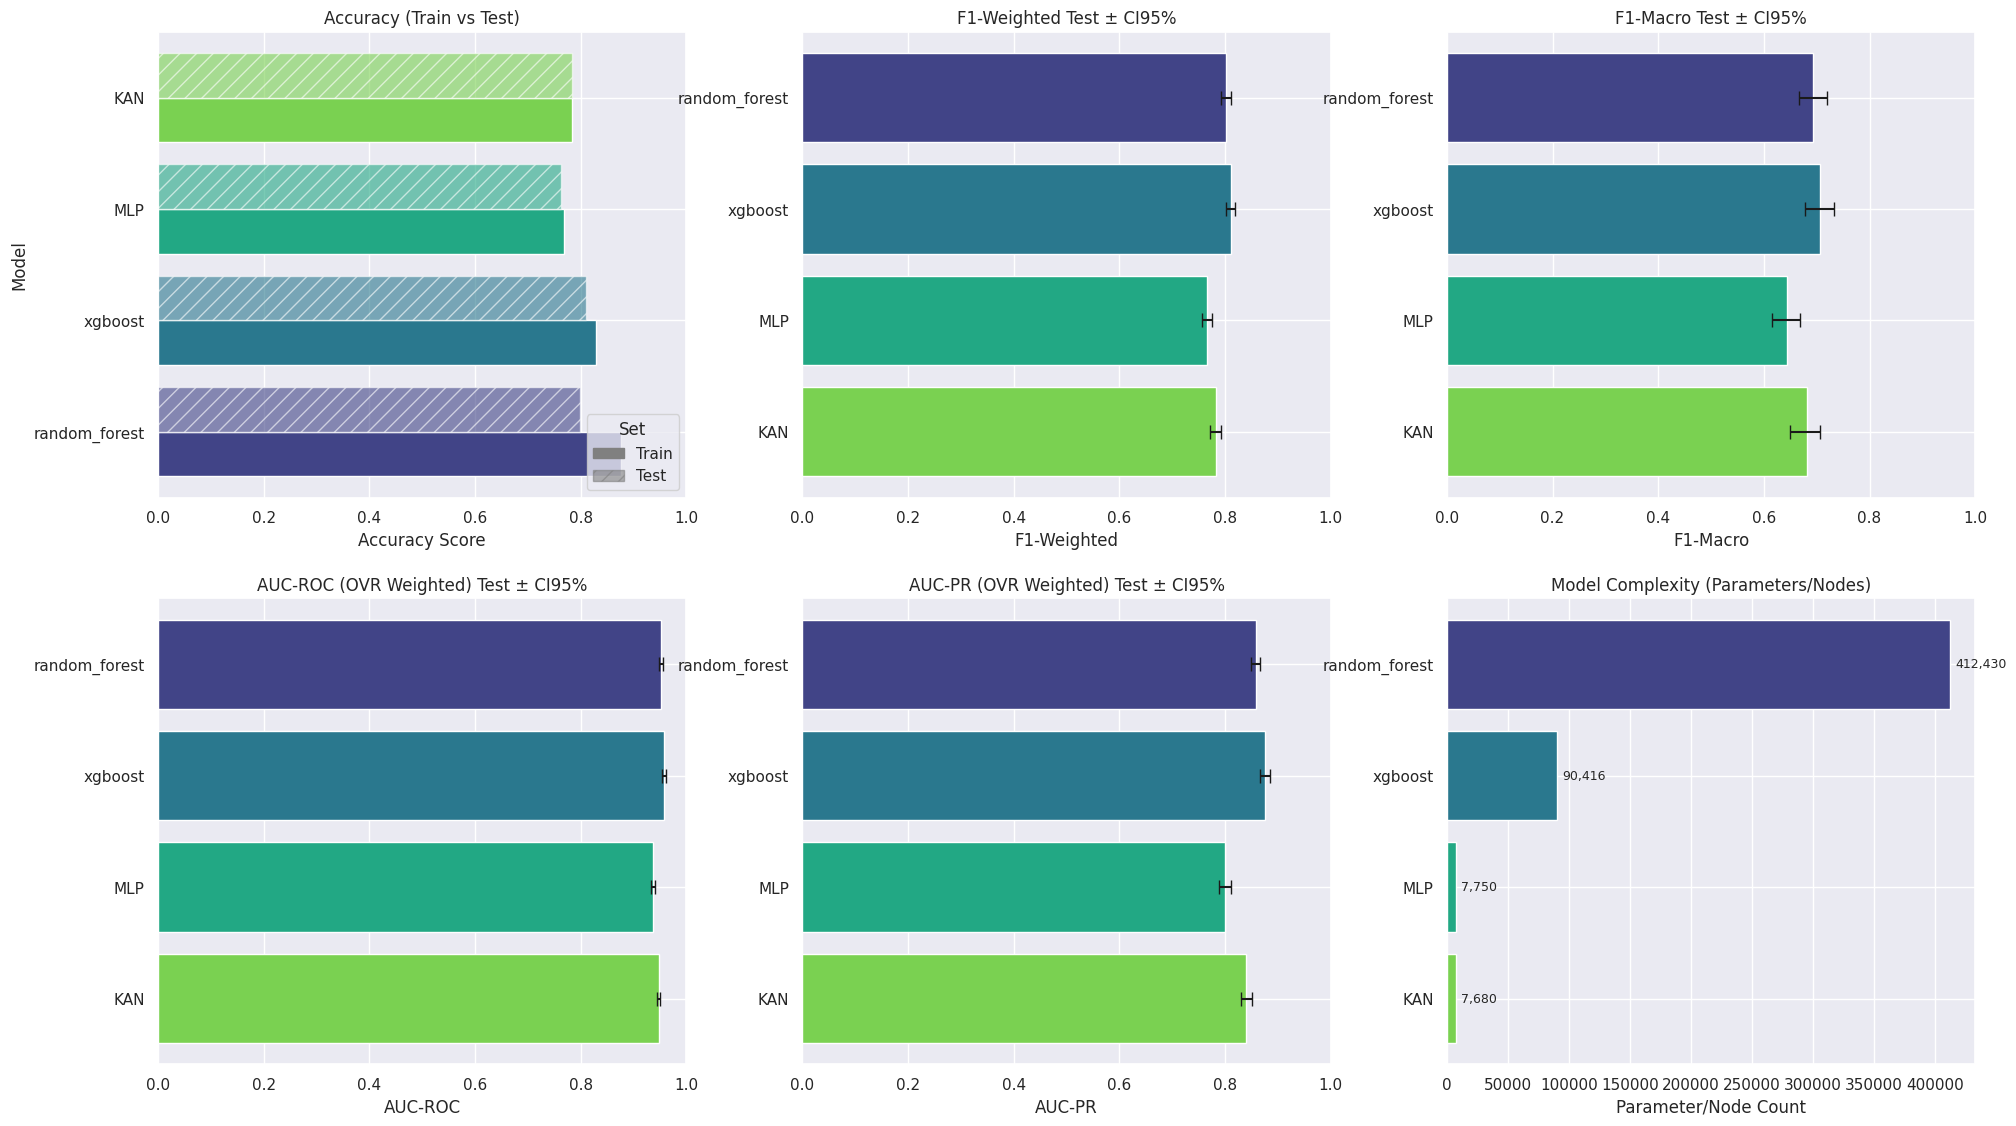

In [50]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [51]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_value = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_value:.4f} | Score: {row['complexity_weighted_score']:.3f}")

Equal Weight (1:1)        -> xgboost         (score: 4.000)
Complexity Weighted (1:2) -> KAN             (score: 5.000)
Extreme Complexity (1:3)  -> KAN             (score: 6.000)
Pareto Approach (40:60)   -> KAN             (score: 0.267)

DETAILED RANKING TABLE


,Param_Count,Avg_Performance,Complexity_Rank,Equal_Rank,Extreme_Rank,Pareto_Rank
Model,,,,,,
KAN,7680,3.0,1,1,1,1
xgboost,90416,1.0,2,1,2,2
MLP,7750,4.0,3,3,2,3
random_forest,412430,2.0,4,3,4,4



RECOMMENDATION
   RECOMMENDED MODEL: KAN
   Reason: Best balance between performance and complexity
   Parameters: 7,680
   F1-Weighted Score: 0.7823
   Complexity-Weighted Rank Score: 5.000

  TOP 3 MODELS (Complexity-Weighted Ranking):
   1. KAN             | Params:    7,680 | F1: 0.7823 | Score: 5.000
   2. xgboost         | Params:   90,416 | F1: 0.8107 | Score: 7.000
   3. MLP             | Params:    7,750 | F1: 0.7654 | Score: 8.000


# Ablation Study MLP e KAN

=== MLP/KAN PRUNING STUDY ===

=== L1 Pruning Study for MLP ===
Total Parameters: 7,750

Testing MLP pruning ratio: 0.0000
  Sparsity: 0.000
  Active params: 7,750 / 7,750
  Compression: 1.00x
  Accuracy: 0.7629
  F1-Weighted: 0.7654
  F1-Macro: 0.6433
  AUC-ROC: 0.9376
  AUC-PR: 0.7997

Testing MLP pruning ratio: 0.1000


  Applied L1 pruning to standalone MLP with ratio: 0.100
  Sparsity: 0.100
  Active params: 6,975 / 7,750
  Compression: 1.11x
  Accuracy: 0.7628
  F1-Weighted: 0.7650
  F1-Macro: 0.6383
  AUC-ROC: 0.9378
  AUC-PR: 0.8004

Testing MLP pruning ratio: 0.2000
  Applied L1 pruning to standalone MLP with ratio: 0.200
  Sparsity: 0.200
  Active params: 6,200 / 7,750
  Compression: 1.25x
  Accuracy: 0.7650
  F1-Weighted: 0.7657
  F1-Macro: 0.6275
  AUC-ROC: 0.9379
  AUC-PR: 0.7996

Testing MLP pruning ratio: 0.3000
  Applied L1 pruning to standalone MLP with ratio: 0.300
  Sparsity: 0.300
  Active params: 5,425 / 7,750
  Compression: 1.43x
  Accuracy: 0.7685
  F1-Weighted: 0.7681
  F1-Macro: 0.6303
  AUC-ROC: 0.9382
  AUC-PR: 0.8008

Testing MLP pruning ratio: 0.5000
  Applied L1 pruning to standalone MLP with ratio: 0.500
  Sparsity: 0.500
  Active params: 3,875 / 7,750
  Compression: 2.00x
  Accuracy: 0.7670
  F1-Weighted: 0.7662
  F1-Macro: 0.6324
  AUC-ROC: 0.9368
  AUC-PR: 0.7989

Testin

  Applied L1 pruning to standalone MLP with ratio: 0.700
  Sparsity: 0.700
  Active params: 2,325 / 7,750
  Compression: 3.33x
  Accuracy: 0.7195
  F1-Weighted: 0.7196
  F1-Macro: 0.5456
  AUC-ROC: 0.9182
  AUC-PR: 0.7232

Testing MLP pruning ratio: 0.8000
  Applied L1 pruning to standalone MLP with ratio: 0.800
  Sparsity: 0.800
  Active params: 1,550 / 7,750
  Compression: 5.00x
  Accuracy: 0.6717
  F1-Weighted: 0.6716
  F1-Macro: 0.4942
  AUC-ROC: 0.9155
  AUC-PR: 0.7090

Testing MLP pruning ratio: 0.9000
  Applied L1 pruning to standalone MLP with ratio: 0.900
  Sparsity: 0.900
  Active params: 775 / 7,750
  Compression: 10.00x
  Accuracy: 0.6644
  F1-Weighted: 0.6324
  F1-Macro: 0.3469
  AUC-ROC: 0.8791
  AUC-PR: 0.6294

Testing MLP pruning ratio: 0.9500
  Applied L1 pruning to standalone MLP with ratio: 0.950
  Sparsity: 0.950
  Active params: 388 / 7,750
  Compression: 19.97x
  Accuracy: 0.3693
  F1-Weighted: 0.2304
  F1-Macro: 0.1022
  AUC-ROC: 0.7793
  AUC-PR: 0.5483

=== L1 P

  Sparsity: 0.000
  Active params: 7,680 / 7,680
  Compression: 1.00x
  Accuracy: 0.7839
  F1-Weighted: 0.7823
  F1-Macro: 0.6812
  AUC-ROC: 0.9477
  AUC-PR: 0.8403

Testing KAN pruning ratio: 0.1000
  Applied L1 pruning to standalone KAN with ratio: 0.100
  Sparsity: 0.113
  Active params: 7,776 / 7,680
  Compression: 0.99x
  Accuracy: 0.7839
  F1-Weighted: 0.7822
  F1-Macro: 0.6809
  AUC-ROC: 0.9476
  AUC-PR: 0.8403

Testing KAN pruning ratio: 0.2000
  Applied L1 pruning to standalone KAN with ratio: 0.200
  Sparsity: 0.225
  Active params: 6,912 / 7,680
  Compression: 1.11x
  Accuracy: 0.7836
  F1-Weighted: 0.7819
  F1-Macro: 0.6788
  AUC-ROC: 0.9477
  AUC-PR: 0.8406

Testing KAN pruning ratio: 0.3000
  Applied L1 pruning to standalone KAN with ratio: 0.300


  Sparsity: 0.338
  Active params: 6,048 / 7,680
  Compression: 1.27x
  Accuracy: 0.7850
  F1-Weighted: 0.7828
  F1-Macro: 0.6795
  AUC-ROC: 0.9479
  AUC-PR: 0.8410

Testing KAN pruning ratio: 0.5000
  Applied L1 pruning to standalone KAN with ratio: 0.500
  Sparsity: 0.562
  Active params: 4,320 / 7,680
  Compression: 1.78x
  Accuracy: 0.7746
  F1-Weighted: 0.7728
  F1-Macro: 0.6520
  AUC-ROC: 0.9427
  AUC-PR: 0.8266

Testing KAN pruning ratio: 0.7000
  Applied L1 pruning to standalone KAN with ratio: 0.700
  Sparsity: 0.787
  Active params: 2,592 / 7,680
  Compression: 2.96x
  Accuracy: 0.7661
  F1-Weighted: 0.7710
  F1-Macro: 0.6518
  AUC-ROC: 0.9423
  AUC-PR: 0.8211

Testing KAN pruning ratio: 0.8000
  Applied L1 pruning to standalone KAN with ratio: 0.800


  Sparsity: 0.900
  Active params: 1,728 / 7,680
  Compression: 4.44x
  Accuracy: 0.7473
  F1-Weighted: 0.7574
  F1-Macro: 0.6289
  AUC-ROC: 0.9345
  AUC-PR: 0.7975

Testing KAN pruning ratio: 0.9000
  Applied L1 pruning to standalone KAN with ratio: 0.900
  Sparsity: 1.012
  Active params: 864 / 7,680
  Compression: 8.89x
  Accuracy: 0.7030
  F1-Weighted: 0.7117
  F1-Macro: 0.5595
  AUC-ROC: 0.9230
  AUC-PR: 0.7741

Testing KAN pruning ratio: 0.9500
  Applied L1 pruning to standalone KAN with ratio: 0.950
  Sparsity: 1.069
  Active params: 432 / 7,680
  Compression: 17.78x
  Accuracy: 0.6777
  F1-Weighted: 0.6875
  F1-Macro: 0.5703
  AUC-ROC: 0.9176
  AUC-PR: 0.7674


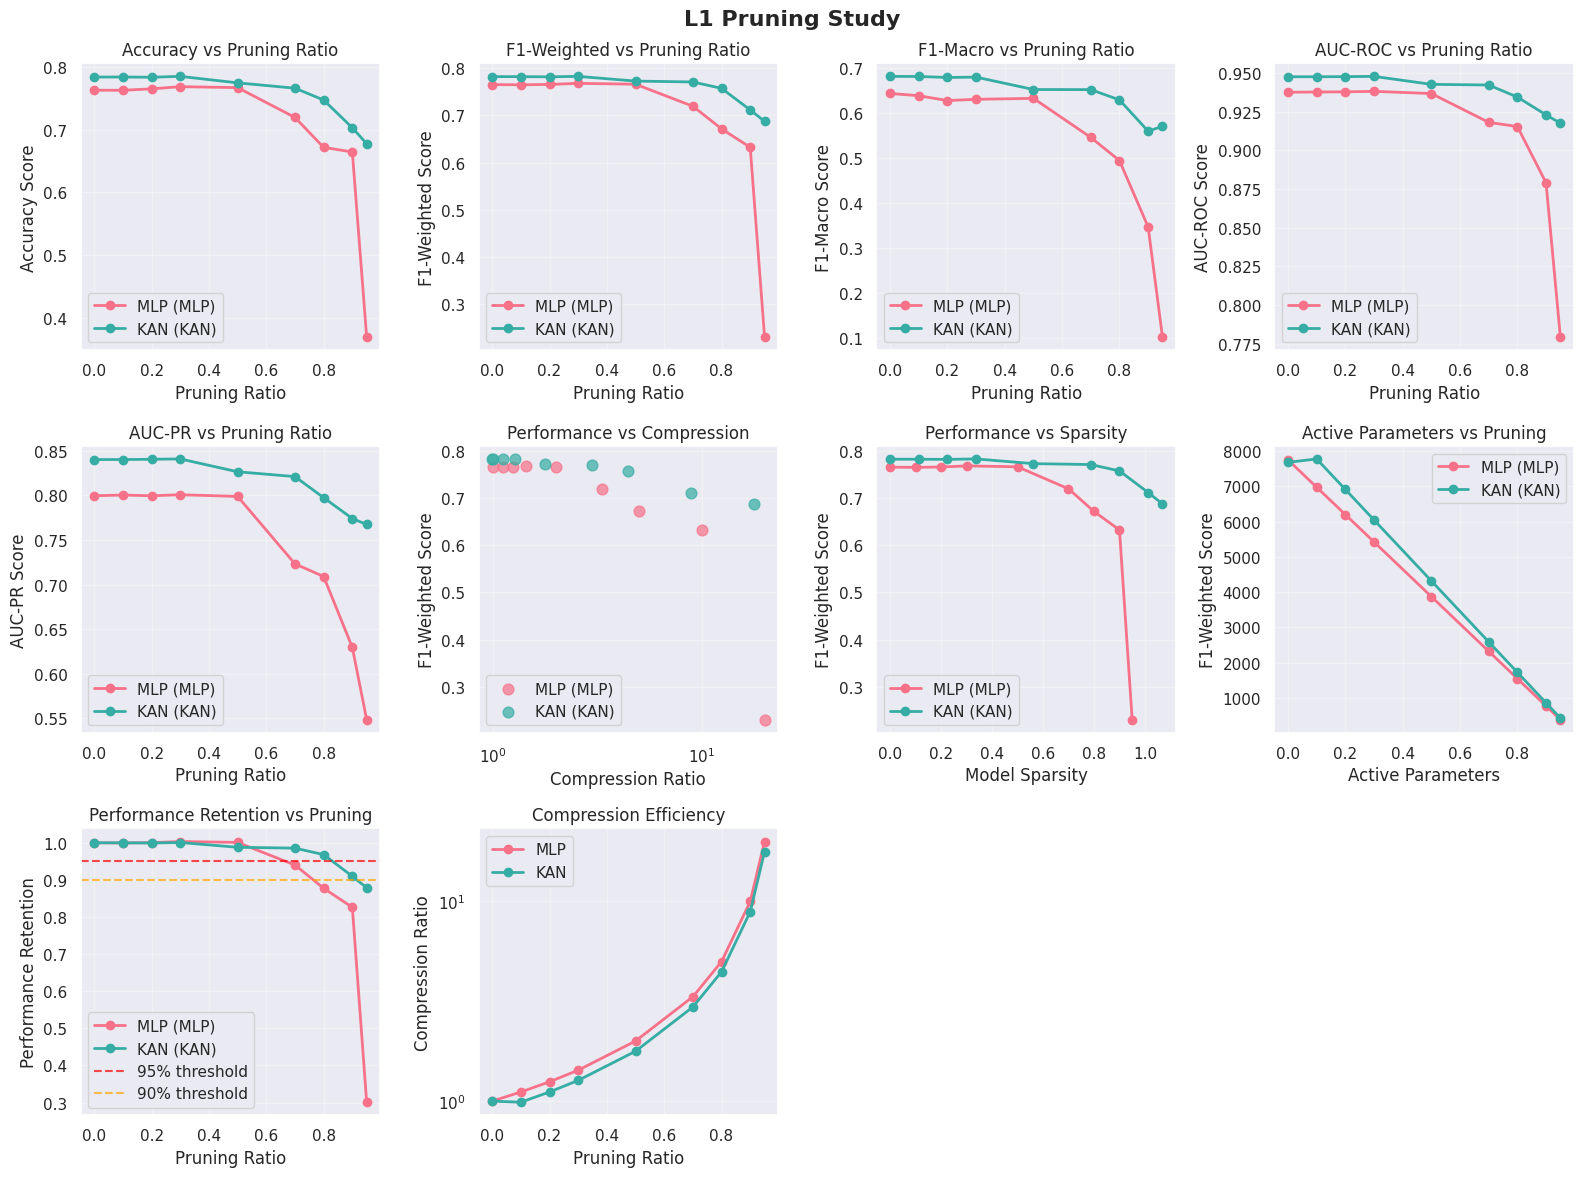


L1 PRUNING STUDY - DETAILED REPORT

MLP Results:
--------------------------------------------------
Model Type: MLP
Total Parameters: 7,750
Baseline F1-Weighted: 0.7654
Significant degradation starts at: 70.0% pruning

Best trade-off point:
  Pruning ratio: 50.0%
  Compression: 2.0x
  F1_Weighted: 0.7662
  Performance loss: -0.1%

Maximum compression achieved: 20.0x

KAN Results:
--------------------------------------------------
Model Type: KAN
Total Parameters: 7,680
Baseline F1-Weighted: 0.7823
Significant degradation starts at: 90.0% pruning

Best trade-off point:
  Pruning ratio: 70.0%
  Compression: 3.0x
  F1_Weighted: 0.7710
  Performance loss: 1.4%

Maximum compression achieved: 17.8x

COMPARATIVE SUMMARY TABLE
Model Type Pruning_Ratio Compression F1_Score Perf_Loss
  MLP  MLP           30%        1.4x   0.7681     -0.3%
  MLP  MLP           50%        2.0x   0.7662     -0.1%
  MLP  MLP           70%        3.3x   0.7196      6.0%
  MLP  MLP           90%       10.0x   0.6324 

,model_name,model_type,pruning_ratio,sparsity,total_params,active_params,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,MLP,MLP,0.00,0.000000,7750,7750,1.000000,0.762918,0.765410,0.643327,0.937622,0.799663
1,MLP,MLP,0.10,0.100000,7750,6975,1.111111,0.762766,0.765005,0.638258,0.937797,0.800440
2,MLP,MLP,0.20,0.200000,7750,6200,1.250000,0.765046,0.765694,0.627483,0.937881,0.799629
3,MLP,MLP,0.30,0.300000,7750,5425,1.428571,0.768541,0.768069,0.630262,0.938203,0.800776
4,MLP,MLP,0.50,0.500000,7750,3875,2.000000,0.767021,0.766197,0.632374,0.936802,0.798914
5,MLP,MLP,0.70,0.700000,7750,2325,3.333333,0.719453,0.719551,0.545594,0.918168,0.723190
6,MLP,MLP,0.80,0.800000,7750,1550,5.000000,0.671733,0.671644,0.494184,0.915454,0.709001
7,MLP,MLP,0.90,0.900000,7750,775,10.000000,0.664438,0.632387,0.346886,0.879080,0.629400
8,MLP,MLP,0.95,0.949935,7750,388,19.974227,0.369301,0.230426,0.102153,0.779283,0.548319
9,KAN,KAN,0.00,0.000000,7680,7680,1.000000,0.783891,0.782290,0.681209,0.947651,0.840296


In [52]:
class StandalonePruningAblationStudy:
    def __init__(self, device='cpu'):
        self.device = device
        self.pruning_results = []

    def get_model_sparsity(self, model):
        """Calcola la sparsità per modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                # Calcola parametri totali KAN usando count_params esistente
                total_params = count_params(model)

                # Conta i parametri zero nella componente KAN
                zero_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        # Accedi ai coefficienti spline (coef parameter)
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            zero_params += float(torch.sum(layer.coef == 0))

                return zero_params / total_params if total_params > 0 else 0.0

            except Exception as e:
                print(f"  Error calculating KAN sparsity: {e}")
                return 0.0

        else:
            # Modello MLP standalone
            zero_params = 0
            total_params = count_params(model)

            # Conta parametri zero in tutti i layer Linear
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        zero_params += float(torch.sum(module.weight == 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        zero_params += float(torch.sum(module.bias == 0))

            return zero_params / total_params if total_params > 0 else 0.0

    def count_active_parameters(self, model):
        """Conta i parametri attivi nei modelli MLP/KAN standalone"""
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                active_params = 0
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            active_params += float(torch.sum(layer.coef != 0))

                return int(active_params)
            except:
                return count_params(model)

        else:
            # Modello MLP standalone
            active_params = 0
            for module in model.modules():
                if isinstance(module, torch.nn.Linear):
                    if hasattr(module, 'weight'):
                        active_params += float(torch.sum(module.weight != 0))
                    if hasattr(module, 'bias') and module.bias is not None:
                        active_params += float(torch.sum(module.bias != 0))

            return int(active_params)


    def apply_l1_pruning_standalone(self, model, pruning_ratio):
        """Applica L1 norm pruning a modelli MLP/KAN standalone"""
        pruned_model = copy.deepcopy(model)

        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            # Modello KAN standalone
            try:
                if pruning_ratio == 0.0:
                    return pruned_model

                # Colleziona tutti i parametri KAN per L1 pruning globale
                kan_modules_to_prune = []
                for i in range(len(model.width) - 1):
                    if i < len(model.act_fun):
                        layer = pruned_model.act_fun[i]
                        if hasattr(layer, 'coef') and layer.coef is not None:
                            temp_module = torch.nn.Linear(1, 1, bias=False)
                            temp_module.weight = torch.nn.Parameter(layer.coef.view(-1, 1))
                            kan_modules_to_prune.append((temp_module, 'weight'))


                if kan_modules_to_prune:
                    # Applica L1 pruning globale sui parametri KAN
                    prune.global_unstructured(
                        kan_modules_to_prune,
                        pruning_method=prune.L1Unstructured,
                        amount=pruning_ratio,
                    )

                    # Applica le maschere ai coefficienti originali
                    idx = 0
                    for i in range(len(model.width) - 1):
                        if i < len(model.act_fun):
                            layer = pruned_model.act_fun[i]
                            if hasattr(layer, 'coef') and layer.coef is not None:
                                original_shape = layer.coef.shape
                                mask = kan_modules_to_prune[idx][0].weight_mask.view(original_shape)
                                layer.coef.data = layer.coef.data * mask
                                idx += 1

                    # Rimuove le maschere temporanee
                    for module, param_name in kan_modules_to_prune:
                        prune.remove(module, param_name)

                print(f"  Applied L1 pruning to standalone KAN with ratio: {pruning_ratio:.3f}")
                return pruned_model

            except Exception as e:
                print(f"  Error during KAN L1 pruning: {e}")
                return model

        else:
            # Modello MLP standalone
            modules_to_prune = []

            # Colleziona tutti i layer Linear
            for module in pruned_model.modules():
                if isinstance(module, torch.nn.Linear):
                    modules_to_prune.append((module, 'weight'))
                    if hasattr(module, 'bias') and module.bias is not None:
                        modules_to_prune.append((module, 'bias'))

            if modules_to_prune:
                # Applica L1 pruning globale
                prune.global_unstructured(
                    modules_to_prune,
                    pruning_method=prune.L1Unstructured,
                    amount=pruning_ratio,
                )

                # Rende permanente il pruning
                for module, param_name in modules_to_prune:
                    prune.remove(module, param_name)

            print(f"  Applied L1 pruning to standalone MLP with ratio: {pruning_ratio:.3f}")
            return pruned_model


    def evaluate_pruned_model(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello pruned su dati tabulari"""
        # Ensure the model is on the correct device
        model.to(self.device)
        model.eval()

        # Converte in tensori, se necessario, e sposta sul device
        if not isinstance(X_test, torch.Tensor):
            X_test = torch.FloatTensor(X_test).to(self.device)
        else:
            X_test = X_test.to(self.device)

        if not isinstance(y_test, torch.Tensor):
            y_test = torch.LongTensor(y_test).to(self.device)
        else:
             y_test = y_test.to(self.device)

        if not isinstance(X_train, torch.Tensor):
            X_train = torch.FloatTensor(X_train).to(self.device)
        else:
            X_train = X_train.to(self.device)

        if not isinstance(y_train, torch.Tensor):
            y_train = torch.LongTensor(y_train).to(self.device)
        else:
            y_train = y_train.to(self.device)


        # Predizioni
        with torch.no_grad():
            # Test set
            outputs_test = model(X_test)
            y_pred_test = torch.argmax(outputs_test, dim=1)
            y_proba_test = F.softmax(outputs_test, dim=1)

            # Train set
            outputs_train = model(X_train)
            y_pred_train = torch.argmax(outputs_train, dim=1)

        # Converte in NumPy per le metriche
        y_pred_test = y_pred_test.cpu().numpy()
        y_true_test = y_test.cpu().numpy()
        y_proba_test = y_proba_test.cpu().numpy()
        y_pred_train = y_pred_train.cpu().numpy()
        y_true_train = y_train.cpu().numpy()


        # Calcola metriche
        accuracy = accuracy_score(y_true_test, y_pred_test)
        f1_weighted = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC
        try:
            auc_roc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')
        except ValueError:
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }


    def run_standalone_pruning_study(self, model, model_name, X_test, y_test, X_train, y_train,
                                   pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]):
        """
        Conduce lo studio di ablazione con L1 pruning su modelli MLP/KAN
        """
        print(f"\n=== L1 Pruning Study for {model_name} ===")

        # Determina il tipo di modello
        if hasattr(model, 'width') and hasattr(model, 'act_fun'):
            model_type = "KAN"
        else:
            model_type = "MLP"

        # Parametri totali usando count_params
        total_params = count_params(model)
        print(f"Total Parameters: {total_params:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting {model_type} pruning ratio: {pruning_ratio:.4f}")

            if pruning_ratio == 0.0:
                # Modello originale
                pruned_model = model
                sparsity = 0.0
                active_params = total_params
            else:
                # Applica L1 pruning
                pruned_model = self.apply_l1_pruning_standalone(model, pruning_ratio)
                pruned_model.to(self.device)
                sparsity = self.get_model_sparsity(pruned_model)
                active_params = self.count_active_parameters(pruned_model)

            # Valuta prestazioni
            metrics = self.evaluate_pruned_model(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Calcola statistiche di compressione
            compression_ratio = total_params / active_params if active_params > 0 else float('inf')

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': model_type,
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_params': total_params,
                'active_params': active_params,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Sparsity: {sparsity:.3f}")
            print(f"  Active params: {active_params:,} / {total_params:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")
            print(f"  F1-Macro: {metrics['f1_macro']:.4f}")
            print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")
            print(f"  AUC-PR: {metrics['auc_pr']:.4f}")


    def plot_standalone_pruning_results(self, figsize=(16, 12)):
        """
        Visualizza i risultati dello studio di pruning
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 4, figsize=figsize)
        fig.suptitle('L1 Pruning Study', fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("husl", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Accuracy Score')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: AUC-ROC vs Pruning Ratio
        ax = axes[0, 3]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['model_type']
            # Filtra i valori NaN per AUC ROC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: AUC-PR vs Pruning Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['model_type']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_pr'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_pr'],
                       marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-PR Score')
        ax.set_title('AUC-PR vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance vs Compression
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({model_type})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 7: Performance vs Sparsity
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['sparsity'], model_data['f1_weighted'],
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Model Sparsity')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Active Parameters vs Pruning
        ax = axes[1, 3]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            model_type = model_data.iloc[0]['model_type']
            ax.plot(model_data['pruning_ratio'], model_data['active_params'],
                    marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Active Parameters')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Active Parameters vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 9: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            model_type = model_data.iloc[0]['model_type']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='o', label=f'{model} ({model_type})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 10: Compression Efficiency
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            ax.plot(model_data['pruning_ratio'], model_data['compression_ratio'],
                   marker='o', label=model, color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Compression Ratio')
        ax.set_title('Compression Efficiency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

        axes[2, 2].axis('off')
        axes[2, 3].axis('off')

        plt.tight_layout()
        plt.show()

    def generate_standalone_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning standalone
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning study first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("L1 PRUNING STUDY - DETAILED REPORT")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_params = baseline_row['total_params']
            model_type = baseline_row['model_type']

            print(f"Model Type: {model_type}")
            print(f"Total Parameters: {total_params:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]
            model_type = baseline['model_type']

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Type': model_type,
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

print("=== MLP/KAN PRUNING STUDY ===")

standalone_pruning_study = StandalonePruningAblationStudy(device=device)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_mlp,
    model_name='MLP',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.run_standalone_pruning_study(
    model=best_model_kan,
    model_name='KAN',
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    X_train=X_tensor,
    y_train=y_tensor,
    pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
)

standalone_pruning_study.plot_standalone_pruning_results()
standalone_pruning_study.generate_standalone_pruning_report()

results_df = pd.DataFrame(standalone_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(results_df)} rows")
print("\nPruning results:")
display(results_df)

# Ablation Study RandomForest e XGBoost

In [53]:
class EnsemblePruningAblationStudy:
    def __init__(self):
        self.pruning_results = []

    def rank_based_pruning_rf(self, rf_model, pruning_ratio):
        """
        Implementa Rank-Based Pruning per Random Forest.
        Rimuove gli alberi con le feature importance più basse.
        """
        if pruning_ratio == 0.0:
            return rf_model, list(range(len(rf_model.estimators_)))

        # Calcola l'importanza di ogni albero basata sulla media delle feature importance
        tree_importances = []
        for i, tree in enumerate(rf_model.estimators_):
            # L'importanza dell'albero è la somma delle importanze delle sue feature
            tree_importance = np.sum(tree.feature_importances_)
            tree_importances.append((i, tree_importance))

        # Ordina gli alberi per importanza (decrescente)
        tree_importances.sort(key=lambda x: x[1], reverse=True)

        # Calcola quanti alberi mantenere
        n_trees_to_keep = max(1, int(len(rf_model.estimators_) * (1 - pruning_ratio)))

        # Seleziona gli indici degli alberi da mantenere
        selected_indices = [idx for idx, _ in tree_importances[:n_trees_to_keep]]
        selected_indices.sort()  # Mantieni l'ordine originale

        # Crea un nuovo modello con solo gli alberi selezionati
        pruned_rf = copy.deepcopy(rf_model)
        pruned_rf.estimators_ = [rf_model.estimators_[i] for i in selected_indices]
        pruned_rf.n_estimators = len(selected_indices)

        return pruned_rf, selected_indices

    def cumulative_pruning_xgb(self, xgb_model, pruning_ratio):
        """
        Implementa Cumulative Pruning per XGBoost.
        Mantiene solo le prime iterazioni di boosting in base al pruning_ratio.
        """
        if pruning_ratio == 0.0:
            return xgb_model, list(range(xgb_model.n_estimators))

        # Ottieni il booster
        original_booster = xgb_model.get_booster()

        # Calcola il numero di alberi da mantenere
        total_trees = xgb_model.n_estimators
        num_classes = xgb_model.n_classes_
        total_rounds = total_trees // num_classes
        keep_rounds = max(1, int(total_rounds * (1 - pruning_ratio)))
        n_keep = keep_rounds * num_classes

        # Crea una copia del modello originale
        pruned_model = copy.deepcopy(xgb_model)
        pruned_model.n_estimators = n_keep

        def predict_pruned(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            predicted_labels = np.argmax(raw_predictions, axis=1)
            return predicted_labels

        def predict_proba(self, X):
            dmat = xgb.DMatrix(X)
            raw_predictions = self.get_booster().predict(dmat, iteration_range=(0, n_keep))
            proba = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
            return proba

        pruned_model.predict = types.MethodType(predict_pruned, pruned_model)
        pruned_model.predict_proba = types.MethodType(predict_proba, pruned_model)

        selected_indices = list(range(n_keep))
        return pruned_model, selected_indices
    
    def calculate_ensemble_sparsity(self, original_count, pruned_count):
        """Calculate sparsity as fraction of components removed"""
        return (original_count - pruned_count) / original_count if original_count > 0 else 0.0

    def evaluate_pruned_ensemble(self, model, model_name, X_test, y_test, X_train, y_train):
        """Valuta le prestazioni di un modello ensemble pruned"""

        # Previsioni
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        # Calcola metriche
        accuracy = accuracy_score(y_test, y_pred_test)
        f1_weighted = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

        # Metriche AUC (se il modello supporta predict_proba)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba_test = model.predict_proba(X_test)
                auc_roc = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
                auc_pr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')
            else:
                auc_roc = np.nan
                auc_pr = np.nan
        except (ValueError, AttributeError):
            auc_roc = np.nan
            auc_pr = np.nan

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr
        }

    def run_rf_pruning_study(self, rf_model, model_name, X_test, y_test, X_train, y_train,
                           pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Rank-Based Pruning su Random Forest
        """
        print(f"\n=== Rank-Based Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = len(rf_model.estimators_)
        print(f"Total Trees: {total_trees:,}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting RF pruning ratio: {pruning_ratio:.2f}")

            # Applica rank-based pruning
            pruned_model, selected_indices = self.rank_based_pruning_rf(rf_model, pruning_ratio)

            # Calcola statistiche
            remaining_trees = len(selected_indices)
            sparsity = self.calculate_ensemble_sparsity(total_trees, remaining_trees)
            compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

            # Valuta prestazioni
            metrics = self.evaluate_pruned_ensemble(
                pruned_model, model_name, X_test, y_test, X_train, y_train
            )

            # Salva risultati
            result = {
                'model_name': model_name,
                'model_type': 'Random Forest',
                'pruning_method': 'Rank-Based',
                'pruning_ratio': pruning_ratio,
                'sparsity': sparsity,
                'total_trees': total_trees,
                'remaining_trees': remaining_trees,
                'compression_ratio': compression_ratio,
                'accuracy': metrics['accuracy'],
                'f1_weighted': metrics['f1_weighted'],
                'f1_macro': metrics['f1_macro'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr']
            }

            self.pruning_results.append(result)

            print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
            print(f"  Compression: {compression_ratio:.2f}x")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

    def run_xgb_pruning_study(self, xgb_model, model_name, X_test, y_test, X_train, y_train,
                            pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        """
        Conduce lo studio di ablazione con Cumulative Pruning su XGBoost
        """
        print(f"\n=== Cumulative Pruning Study for {model_name} ===")

        # Parametri totali (numero di alberi)
        total_trees = xgb_model.n_estimators
        print(f"Total Trees: {total_trees:,}")
        print(f"Number of Classes: {xgb_model.n_classes_}")

        for pruning_ratio in pruning_ratios:
            print(f"\nTesting XGB pruning ratio: {pruning_ratio:.2f}")

            try:
                # Applica cumulative pruning
                pruned_model, selected_indices = self.cumulative_pruning_xgb(xgb_model, pruning_ratio)

                # Calcola statistiche
                remaining_trees = len(selected_indices)
                sparsity = self.calculate_ensemble_sparsity(total_trees, remaining_trees)
                compression_ratio = total_trees / remaining_trees if remaining_trees > 0 else float('inf')

                # Valuta prestazioni
                metrics = self.evaluate_pruned_ensemble(
                    pruned_model, model_name, X_test, y_test, X_train, y_train
                )

                # Salva risultati
                result = {
                    'model_name': model_name,
                    'model_type': 'XGBoost',
                    'pruning_method': 'Cumulative',
                    'sparsity': sparsity,
                    'pruning_ratio': pruning_ratio,
                    'total_trees': total_trees,
                    'remaining_trees': remaining_trees,
                    'compression_ratio': compression_ratio,
                    'accuracy': metrics['accuracy'],
                    'f1_weighted': metrics['f1_weighted'],
                    'f1_macro': metrics['f1_macro'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr']
                }

                self.pruning_results.append(result)

                print(f"  Remaining trees: {remaining_trees:,} / {total_trees:,}")
                print(f"  Compression: {compression_ratio:.2f}x")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1-Weighted: {metrics['f1_weighted']:.4f}")

            except Exception as e:
                print(f"  Error during XGB pruning at ratio {pruning_ratio}: {e}")
                continue

    def plot_ensemble_pruning_results(self, figsize=(18, 12)):
        """
        Visualizza i risultati dello studio di pruning per modelli ensemble
        """
        if not self.pruning_results:
            print("No pruning results to plot. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        fig, axes = plt.subplots(3, 4, figsize=figsize)
        fig.suptitle('Ensemble Pruning Study Results - Random Forest & XGBoost',
                     fontsize=16, fontweight='bold')

        models = df['model_name'].unique()
        colors = sns.color_palette("Set1", len(models))

        # Plot 1: Accuracy vs Pruning Ratio
        ax = axes[0, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['accuracy'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Accuracy Score')
        ax.set_title('Accuracy vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 2: F1-Weighted vs Pruning Ratio
        ax = axes[0, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_weighted'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('F1-Weighted vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 3: F1-Macro vs Pruning Ratio
        ax = axes[0, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['f1_macro'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('F1-Macro Score')
        ax.set_title('F1-Macro vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 4: AUC-ROC vs Pruning Ratio
        ax = axes[0, 3]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_roc'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_roc'],
                       marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-ROC Score')
        ax.set_title('AUC-ROC vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 5: AUC-PR vs Pruning Ratio
        ax = axes[1, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            # Filtra i valori NaN per AUC
            valid_mask = ~np.isnan(model_data['auc_pr'])
            if valid_mask.any():
                valid_data = model_data[valid_mask]
                ax.plot(valid_data['pruning_ratio'], valid_data['auc_pr'],
                       marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('AUC-PR Score')
        ax.set_title('AUC-PR vs Pruning Ratio')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 6: Performance vs Compression
        ax = axes[1, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            finite_mask = np.isfinite(model_data['compression_ratio'])
            if finite_mask.any():
                ax.scatter(model_data.loc[finite_mask, 'compression_ratio'],
                          model_data.loc[finite_mask, 'f1_weighted'],
                          label=f'{model} ({method})', color=colors[i], s=60, alpha=0.7)
        ax.set_xlabel('Compression Ratio')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Compression')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')

        # Plot 7: Sparsity vs Performance
        ax = axes[1, 2]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['sparsity'], model_data['f1_weighted'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Sparsity (Fraction Removed)')
        ax.set_ylabel('F1-Weighted Score')
        ax.set_title('Performance vs Sparsity')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 8: Active Components vs Pruning
        ax = axes[1, 3]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['remaining_trees'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Active Components (Trees/Estimators)')
        ax.set_title('Active Components vs Pruning')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

        # Plot 9: Performance Retention
        ax = axes[2, 0]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model].sort_values('pruning_ratio')
            method = model_data.iloc[0]['pruning_method']
            baseline_f1 = model_data.iloc[0]['f1_weighted']
            performance_retention = model_data['f1_weighted'] / baseline_f1
            ax.plot(model_data['pruning_ratio'], performance_retention,
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Performance Retention')
        ax.set_title('Performance Retention vs Pruning')
        ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
        ax.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Plot 10: Compression Efficiency
        ax = axes[2, 1]
        for i, model in enumerate(models):
            model_data = df[df['model_name'] == model]
            method = model_data.iloc[0]['pruning_method']
            ax.plot(model_data['pruning_ratio'], model_data['compression_ratio'],
                   marker='o', label=f'{model} ({method})', color=colors[i], linewidth=2)
        ax.set_xlabel('Pruning Ratio')
        ax.set_ylabel('Compression Ratio')
        ax.set_title('Compression Efficiency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')

        axes[2, 2].axis('off')
        axes[2, 3].axis('off')

        plt.tight_layout()
        plt.show()

    def generate_ensemble_pruning_report(self):
        """
        Genera un report dettagliato per i risultati del pruning ensemble
        """
        if not self.pruning_results:
            print("No pruning results available. Run pruning studies first.")
            return

        df = pd.DataFrame(self.pruning_results)

        print("\n" + "="*80)
        print("ENSEMBLE PRUNING STUDY - DETAILED REPORT")
        print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
        print("="*80)

        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name].sort_values('pruning_ratio')

            print(f"\n{model_name} Results:")
            print("-" * 50)

            # Informazioni base
            baseline_row = model_data.iloc[0]
            baseline_f1 = baseline_row['f1_weighted']
            total_trees = baseline_row['total_trees']
            model_type = baseline_row['model_type']
            pruning_method = baseline_row['pruning_method']

            print(f"Model Type: {model_type}")
            print(f"Pruning Method: {pruning_method}")
            print(f"Total Trees: {total_trees:,}")
            print(f"Baseline F1-Weighted: {baseline_f1:.4f}")

            # Trova il punto di degradazione significativa (>5% loss in F1)
            degradation_point = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss > 0.05:  # 5% degradation threshold
                    degradation_point = row['pruning_ratio']
                    break

            if degradation_point:
                print(f"Significant degradation starts at: {degradation_point:.1%} pruning")
            else:
                print("No significant degradation observed within tested range")

            # Migliore trade-off (massima compressione con <2% loss)
            best_tradeoff = None
            for _, row in model_data.iterrows():
                f1_loss = (baseline_f1 - row['f1_weighted']) / baseline_f1
                if f1_loss <= 0.02 and row['pruning_ratio'] > 0:
                    best_tradeoff = row

            if best_tradeoff is not None:
                print(f"\nBest trade-off point:")
                print(f"  Pruning ratio: {best_tradeoff['pruning_ratio']:.1%}")
                print(f"  Trees: {best_tradeoff['remaining_trees']:,} / {total_trees:,}")
                print(f"  Compression: {best_tradeoff['compression_ratio']:.1f}x")
                print(f"  F1_Weighted: {best_tradeoff['f1_weighted']:.4f}")
                print(f"  Performance loss: {((baseline_f1 - best_tradeoff['f1_weighted'])/baseline_f1)*100:.1f}%")

            # Statistiche di compressione
            max_compression = model_data['compression_ratio'].replace([np.inf, -np.inf], np.nan).max()
            if not np.isnan(max_compression):
                print(f"\nMaximum compression achieved: {max_compression:.1f}x")

        # Tabella comparativa
        print(f"\n{'='*80}")
        print("COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS")
        print("="*80)

        summary_rows = []
        for model_name in df['model_name'].unique():
            model_data = df[df['model_name'] == model_name]
            baseline = model_data[model_data['pruning_ratio'] == 0.0].iloc[0]

            # Trova risultati a diverse soglie di pruning
            for target_ratio in [0.3, 0.5, 0.7, 0.9]:
                closest = model_data.iloc[(model_data['pruning_ratio'] - target_ratio).abs().argsort()].iloc[0]
                if abs(closest['pruning_ratio'] - target_ratio) < 0.1:  # Se abbastanza vicino
                    performance_loss = ((baseline['f1_weighted'] - closest['f1_weighted']) / baseline['f1_weighted']) * 100
                    trees_reduction = ((baseline['total_trees'] - closest['remaining_trees']) / baseline['total_trees']) * 100
                    summary_rows.append({
                        'Model': model_name,
                        'Method': baseline['pruning_method'],
                        'Pruning_Ratio': f"{target_ratio:.0%}",
                        'Trees_Kept': f"{closest['remaining_trees']:,}",
                        'Trees_Reduction': f"{trees_reduction:.0f}%",
                        'Compression': f"{closest['compression_ratio']:.1f}x",
                        'F1_Score': f"{closest['f1_weighted']:.4f}",
                        'Perf_Loss': f"{performance_loss:.1f}%"
                    })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            print(summary_df.to_string(index=False))

ENSEMBLE PRUNING ABLATION STUDY
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning
Random Forest model extracted successfully

=== Rank-Based Pruning Study for Random Forest ===
Total Trees: 100

Testing RF pruning ratio: 0.00


  Remaining trees: 100 / 100
  Compression: 1.00x
  Accuracy: 0.7986
  F1-Weighted: 0.8011

Testing RF pruning ratio: 0.10


  Remaining trees: 90 / 100
  Compression: 1.11x
  Accuracy: 0.7982
  F1-Weighted: 0.8005

Testing RF pruning ratio: 0.20


  Remaining trees: 80 / 100
  Compression: 1.25x
  Accuracy: 0.7986
  F1-Weighted: 0.8010

Testing RF pruning ratio: 0.30


  Remaining trees: 70 / 100
  Compression: 1.43x
  Accuracy: 0.7965
  F1-Weighted: 0.7989

Testing RF pruning ratio: 0.40


  Remaining trees: 60 / 100
  Compression: 1.67x
  Accuracy: 0.7941
  F1-Weighted: 0.7966

Testing RF pruning ratio: 0.50


  Remaining trees: 50 / 100
  Compression: 2.00x
  Accuracy: 0.7951
  F1-Weighted: 0.7974

Testing RF pruning ratio: 0.60


  Remaining trees: 40 / 100
  Compression: 2.50x
  Accuracy: 0.7933
  F1-Weighted: 0.7956

Testing RF pruning ratio: 0.70


  Remaining trees: 30 / 100
  Compression: 3.33x
  Accuracy: 0.7951
  F1-Weighted: 0.7974

Testing RF pruning ratio: 0.80


  Remaining trees: 19 / 100
  Compression: 5.26x
  Accuracy: 0.7932
  F1-Weighted: 0.7956

Testing RF pruning ratio: 0.90
  Remaining trees: 9 / 100
  Compression: 11.11x
  Accuracy: 0.7856
  F1-Weighted: 0.7878

Testing RF pruning ratio: 0.95


  Remaining trees: 5 / 100
  Compression: 20.00x
  Accuracy: 0.7748
  F1-Weighted: 0.7771
XGBoost model extracted successfully

=== Cumulative Pruning Study for XGBoost ===
Total Trees: 300
Number of Classes: 6

Testing XGB pruning ratio: 0.00


  Remaining trees: 300 / 300
  Compression: 1.00x
  Accuracy: 0.8097
  F1-Weighted: 0.8107

Testing XGB pruning ratio: 0.10


  Remaining trees: 270 / 300
  Compression: 1.11x
  Accuracy: 0.8071
  F1-Weighted: 0.8088

Testing XGB pruning ratio: 0.20


  Remaining trees: 240 / 300
  Compression: 1.25x
  Accuracy: 0.8073
  F1-Weighted: 0.8093

Testing XGB pruning ratio: 0.30


  Remaining trees: 210 / 300
  Compression: 1.43x
  Accuracy: 0.8050
  F1-Weighted: 0.8075

Testing XGB pruning ratio: 0.40


  Remaining trees: 180 / 300
  Compression: 1.67x
  Accuracy: 0.8026
  F1-Weighted: 0.8057

Testing XGB pruning ratio: 0.50


  Remaining trees: 150 / 300
  Compression: 2.00x
  Accuracy: 0.8000
  F1-Weighted: 0.8038

Testing XGB pruning ratio: 0.60


  Remaining trees: 120 / 300
  Compression: 2.50x
  Accuracy: 0.7936
  F1-Weighted: 0.7982

Testing XGB pruning ratio: 0.70


  Remaining trees: 90 / 300
  Compression: 3.33x
  Accuracy: 0.7877
  F1-Weighted: 0.7931

Testing XGB pruning ratio: 0.80
  Remaining trees: 54 / 300
  Compression: 5.56x
  Accuracy: 0.7809
  F1-Weighted: 0.7873

Testing XGB pruning ratio: 0.90


  Remaining trees: 24 / 300
  Compression: 12.50x
  Accuracy: 0.7757
  F1-Weighted: 0.7829

Testing XGB pruning ratio: 0.95
  Remaining trees: 12 / 300
  Compression: 25.00x
  Accuracy: 0.7746
  F1-Weighted: 0.7820


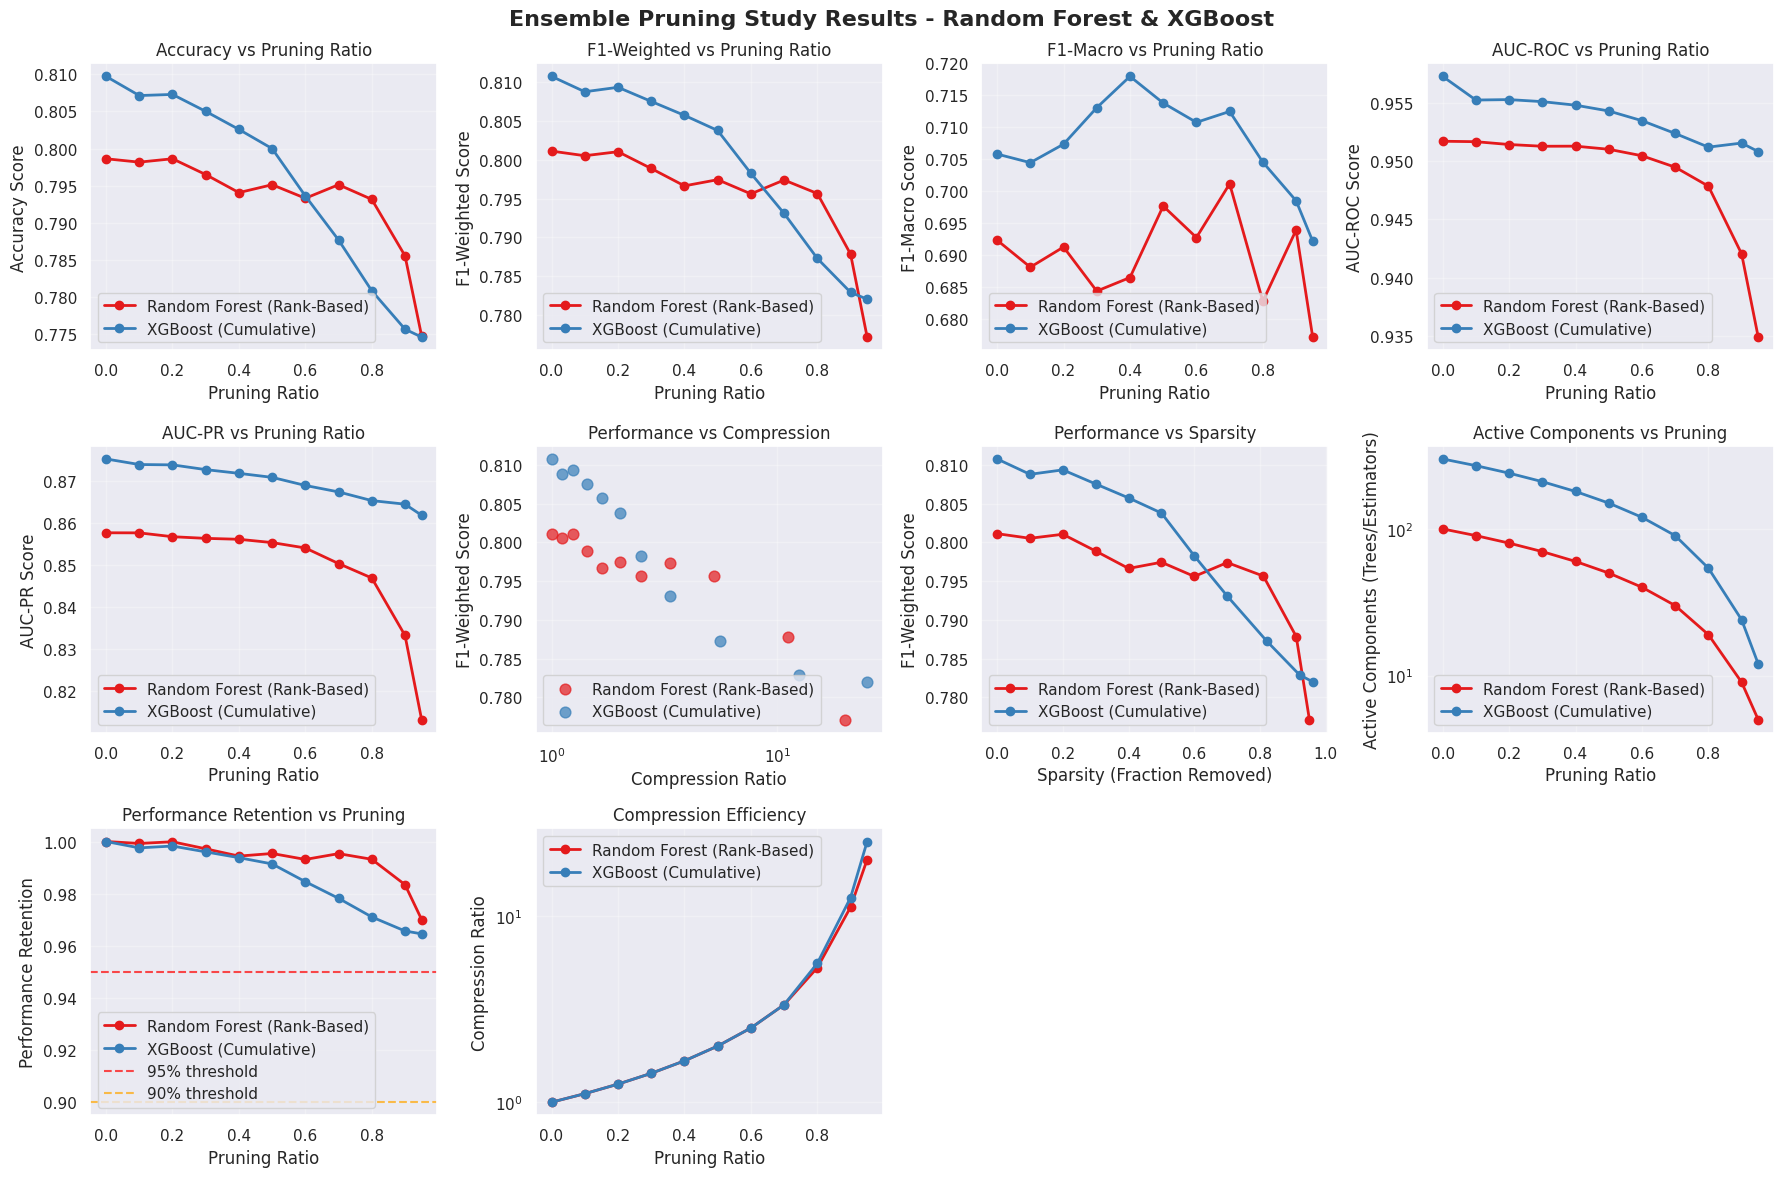


ENSEMBLE PRUNING STUDY - DETAILED REPORT
Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning

Random Forest Results:
--------------------------------------------------
Model Type: Random Forest
Pruning Method: Rank-Based
Total Trees: 100
Baseline F1-Weighted: 0.8011
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 90.0%
  Trees: 9 / 100
  Compression: 11.1x
  F1_Weighted: 0.7878
  Performance loss: 1.7%

Maximum compression achieved: 20.0x

XGBoost Results:
--------------------------------------------------
Model Type: XGBoost
Pruning Method: Cumulative
Total Trees: 300
Baseline F1-Weighted: 0.8107
No significant degradation observed within tested range

Best trade-off point:
  Pruning ratio: 60.0%
  Trees: 120 / 300
  Compression: 2.5x
  F1_Weighted: 0.7982
  Performance loss: 1.5%

Maximum compression achieved: 25.0x

COMPARATIVE SUMMARY TABLE - ENSEMBLE MODELS
        Model     Method Pruning_Ratio Trees_Kept Trees_Reductio

,model_name,model_type,pruning_method,pruning_ratio,sparsity,total_trees,remaining_trees,compression_ratio,accuracy,f1_weighted,f1_macro,auc_roc,auc_pr
0,Random Forest,Random Forest,Rank-Based,0.00,0.00,100,100,1.000000,0.798632,0.801116,0.692315,0.951707,0.857684
1,Random Forest,Random Forest,Rank-Based,0.10,0.10,100,90,1.111111,0.798176,0.800518,0.688080,0.951669,0.857667
2,Random Forest,Random Forest,Rank-Based,0.20,0.20,100,80,1.250000,0.798632,0.801036,0.691240,0.951427,0.856753
3,Random Forest,Random Forest,Rank-Based,0.30,0.30,100,70,1.428571,0.796505,0.798872,0.684339,0.951277,0.856361
4,Random Forest,Random Forest,Rank-Based,0.40,0.40,100,60,1.666667,0.794073,0.796633,0.686462,0.951285,0.856142
5,Random Forest,Random Forest,Rank-Based,0.50,0.50,100,50,2.000000,0.795137,0.797431,0.697654,0.951018,0.855355
6,Random Forest,Random Forest,Rank-Based,0.60,0.60,100,40,2.500000,0.793313,0.795602,0.692725,0.950462,0.854077
7,Random Forest,Random Forest,Rank-Based,0.70,0.70,100,30,3.333333,0.795137,0.797389,0.701136,0.949484,0.850370
8,Random Forest,Random Forest,Rank-Based,0.80,0.81,100,19,5.263158,0.793161,0.795649,0.682739,0.947856,0.846943
9,Random Forest,Random Forest,Rank-Based,0.90,0.91,100,9,11.111111,0.785562,0.787848,0.693889,0.942049,0.833294


In [54]:
print("ENSEMBLE PRUNING ABLATION STUDY")
print("Random Forest: Rank-Based Pruning | XGBoost: Cumulative Pruning")
print("="*100)

ensemble_pruning_study = EnsemblePruningAblationStudy()

pruning_ratios_ensemble = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

try:
    if 'tree' in gs_rf.best_estimator_.named_steps:
        rf_final_model = gs_rf.best_estimator_.named_steps['tree']
    else:
        raise ValueError("Random Forest model not found")

    print("Random Forest model extracted successfully")

    ensemble_pruning_study.run_rf_pruning_study(
        rf_model=rf_final_model,
        model_name='Random Forest',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with Random Forest model: {e}")

try:
    if 'xgb' in gs_xgb.best_estimator_.named_steps:
        xgb_final_model = gs_xgb.best_estimator_.named_steps['xgb']
    else:
        raise ValueError("XGBoost model not found")

    print("XGBoost model extracted successfully")

    ensemble_pruning_study.run_xgb_pruning_study(
        xgb_model=xgb_final_model,
        model_name='XGBoost',
        X_test=X_test_processed,
        y_test=y_test_0_indexed,
        X_train=X_train_processed,
        y_train=y_train_0_indexed,
        pruning_ratios=pruning_ratios_ensemble
    )

except Exception as e:
    print(f"Error with XGBoost model: {e}")

ensemble_pruning_study.plot_ensemble_pruning_results()
ensemble_pruning_study.generate_ensemble_pruning_report()

ensemble_results_df = pd.DataFrame(ensemble_pruning_study.pruning_results)
print(f"\nResults saved to DataFrame with {len(ensemble_results_df)} rows")
print("\nPruning results:")
display(ensemble_results_df)

# Ablation Study Comparation

In [55]:
def compare_all_pruning_methods():
    """
    Compare pruning effectiveness across all model types
    """
    print("\n" + "="*120)
    print("COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS")
    print("="*120)

    # Collect data from both studies
    all_models_comparison = []

    # Neural network results
    for _, result in results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Neural Network',
                'Pruning_Method': 'L1 Norm',
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Components': f"{result['active_params']}/{result['total_params']}"
            })

    # Ensemble results
    for _, result in ensemble_results_df.iterrows():
        if result['pruning_ratio'] in [0.0, 0.3, 0.5, 0.7, 0.9]:
            pruning_method = 'Rank-Based' if result['model_name'] == 'Random Forest' else 'Cumulative'
            all_models_comparison.append({
                'Model': result['model_name'],
                'Type': 'Ensemble',
                'Pruning_Method': pruning_method,
                'Pruning_Ratio': result['pruning_ratio'],
                'Accuracy_Test': result['accuracy'],
                'F1_Weighted_Test': result['f1_weighted'],
                'F1_Macro_Test': result['f1_macro'],
                'AUC_ROC_Test': result['auc_roc'],
                'AUC_PR_Test': result['auc_pr'],
                'Compression': result['compression_ratio'],
                'Trees': f"{result['remaining_trees']}/{result['total_trees']}"
            })

    if all_models_comparison:
        comparison_df = pd.DataFrame(all_models_comparison)

        # Create pivot table for better visualization
        pivot_accuracy = comparison_df.pivot_table(
            values='Accuracy_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_weighted = comparison_df.pivot_table(
            values='F1_Weighted_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_f1_macro = comparison_df.pivot_table(
            values='F1_Macro_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_roc = comparison_df.pivot_table(
            values='AUC_ROC_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )
        pivot_auc_pr = comparison_df.pivot_table(
            values='AUC_PR_Test',
            index=['Model', 'Type', 'Pruning_Method'],
            columns='Pruning_Ratio',
            fill_value=np.nan
        )

        print("\nAccuracy Performance Across Pruning Levels:")
        print(pivot_accuracy.round(4))

        print("\nF1 Weighted Performance Across Pruning Levels:")
        print(pivot_f1_weighted.round(4))

        print("\nF1 Macro Performance Across Pruning Levels:")
        print(pivot_f1_macro.round(4))

        print("\nAUC_ROC Weighted Performance Across Pruning Levels:")
        print(pivot_auc_roc.round(4))

        print("\nAUC_PR Weighted Performance Across Pruning Levels:")
        print(pivot_auc_pr.round(4))

        pruning_levels = [0.3, 0.5, 0.7, 0.9]

        print(f"\n{'='*120}")
        print("PERFORMANCE RETENTION AT DIFFERENT PRUNING LEVELS")
        print("="*120)

        for pruning_level in pruning_levels:
            print(f"\n{'-'*60}")
            print(f"PERFORMANCE RETENTION AT {int(pruning_level*100)}% PRUNING")
            print(f"{'-'*60}")

            retention_summary = []
            for model in comparison_df['Model'].unique():
                model_data = comparison_df[comparison_df['Model'] == model]
                baseline = model_data[model_data['Pruning_Ratio'] == 0.0]
                pruned = model_data[model_data['Pruning_Ratio'] == pruning_level]

                if len(baseline) > 0 and len(pruned) > 0:
                    baseline_f1_weighted = baseline.iloc[0]['F1_Weighted_Test']
                    pruned_f1_weighted = pruned.iloc[0]['F1_Weighted_Test']
                    retention = pruned_f1_weighted / baseline_f1_weighted if baseline_f1_weighted != 0 else 0

                    retention_summary.append({
                        'Model': model,
                        'Type': baseline.iloc[0]['Type'],
                        'Method': baseline.iloc[0]['Pruning_Method'],
                        'Baseline_Accuracy': baseline_f1_weighted,
                        'Pruned_Accuracy': pruned_f1_weighted,
                        'Retention': retention,
                        'Compression': pruned.iloc[0]['Compression']
                    })

            if retention_summary:
                retention_df = pd.DataFrame(retention_summary).sort_values('Retention', ascending=False)
                print(retention_df.round(4))

            best_model = retention_df.iloc[0]
            print(f"\nBEST PRUNING METHOD AT {int(pruning_level*100)}% LEVEL:")
            print(f"Model: {best_model['Model']} ({best_model['Type']})")
            print(f"Method: {best_model['Method']}")
            print(f"Performance Retention: {best_model['Retention']:.1%}")
            print(f"Compression Achieved: {best_model['Compression']:.1f}x")

    else:
        print("No pruning results available for comparison.")

# Run comprehensive comparison
compare_all_pruning_methods()

print("\n" + "="*120)
print("ABLATION STUDY COMPLETE")


COMPREHENSIVE PRUNING COMPARISON: NEURAL NETWORKS vs ENSEMBLE METHODS

Accuracy Performance Across Pruning Levels:
Pruning_Ratio                                   0.0     0.3     0.5     0.7  \
Model         Type           Pruning_Method                                   
KAN           Neural Network L1 Norm         0.7839  0.7850  0.7746  0.7661   
MLP           Neural Network L1 Norm         0.7629  0.7685  0.7670  0.7195   
Random Forest Ensemble       Rank-Based      0.7986  0.7965  0.7951  0.7951   
XGBoost       Ensemble       Cumulative      0.8097  0.8050  0.8000  0.7877   

Pruning_Ratio                                   0.9  
Model         Type           Pruning_Method          
KAN           Neural Network L1 Norm         0.7030  
MLP           Neural Network L1 Norm         0.6644  
Random Forest Ensemble       Rank-Based      0.7856  
XGBoost       Ensemble       Cumulative      0.7757  

F1 Weighted Performance Across Pruning Levels:
Pruning_Ratio                        